# Top Mass DCTR 1D - $m_{jjj}$

This notebook attempts to train and validate a DCTR model paramterized by the top mass only using reconstructed hadronic mass $m_{jjj}$ for each event

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Process Data

In [3]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/asuresh/DCTRFitting/'

In [4]:
# fetch m_T vals from default dataset
train_dataset_0_mT_x4 = np.load(data_dir + 'part_172_5_6j_x4.npy')[:, :1, 5]
train_dataset_0_mT = train_dataset_0_mT_x4

print(np.shape(train_dataset_0_mT))

# fetch m_jjj vals from default dataset
train_dataset_0_obs_x4 = np.load(data_dir +
                                  'part_172_5_6j_obs_x4.npy')[:, :2]
train_dataset_0_obs = train_dataset_0_obs_x4

print(np.shape(train_dataset_0_obs))

# fetch m_T vals from varied dataset
train_dataset_1_mT_x4 = np.load(data_dir + 'part_varmass_6j_x4.npy')[:, :1, 5]
train_dataset_1_mT = train_dataset_1_mT_x4

print(np.shape(train_dataset_1_mT))

# fetch m_jjj vals from varied dataset
train_dataset_1_obs_x4 = np.load(data_dir + 'part_varmass_6j_obs_x4.npy')[:, :2]
train_dataset_1_obs = train_dataset_1_obs_x4#[:len(train_dataset_0_mjjj)]

print(np.shape(train_dataset_1_obs))

(266007, 1)
(266007, 2)
(1021017, 1)
(1021017, 2)


The model will see an unequal number of events from the uniformly sampled mass data and the fixed mass data. We will have to correct this with a liklihood ratio factor when reweighting.

In [5]:
X0 = np.concatenate((train_dataset_0_obs, train_dataset_0_mT), axis = 1)
X1 = np.concatenate((train_dataset_1_obs, train_dataset_1_mT), axis = 1)

print(np.shape(X0))
print(np.shape(X1))

print(len(X1)/len(X0)) # different sizes if != 1

(266007, 3)
(1021017, 3)
3.838308766310661


In [6]:
Y0 = np.zeros_like(X0[:,0])
Y1 = np.ones_like(X1[:,0])

In [7]:
X = np.concatenate((X0, X1), axis = 0)
X /= 1000.
Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [8]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [9]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(1029620, 3)
(1029620, 2)
(257404, 3)
(257404, 2)


## Build Model

In [10]:
inputs = Input((3,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs = inputs, outputs = outputs)
dctr.compile(loss='categorical_crossentropy', optimizer='Adam')

dctr.summary()

earlystopping = EarlyStopping(patience=15, restore_best_weights=True)






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 5,402
Trainable params: 5,402
Non-trainable params: 0
_________________________________________________________________


## Train model

### Define reweighting function

We must calculate two liklihood ratios during reweighting: the first because the training datasets were different sizes, and the second because the validation datasets are different sizes.

In [38]:
# Get predicted probabilities
def reweight(default_dataset, mT):
    #creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape = (default_dataset.shape[0],1)) * mT
    #combining and reshaping into correct format:
    model_inputs = K.concatenate((default_dataset, concat_input_and_params), axis=-1)

    f = dctr(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

In [12]:
test_dataset_0_obs = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,:2]
test_dataset_1_obs = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,:2]

print(np.shape(test_dataset_0_obs))
print(np.shape(test_dataset_1_obs))

X0_test = np.concatenate((test_dataset_0_obs, 172.5*np.ones_like(test_dataset_0_obs)), axis = 1)
X1_test = np.concatenate((test_dataset_0_obs, 175.0*np.ones_like(test_dataset_0_obs)), axis = 1)

(66779, 2)
(68260, 2)


### Validating Reweighting

In [13]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

In [14]:
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

In [15]:
def plt_hist_to_cv(np_histogram_output):
    counts, bin_edges, _ = np_histogram_output
    return counts.ravel().astype('float32')

Model has a tendency to initialize at trivial minima of the loss function (loss ~ 12 or loss ~4); the mode's outputs are all [1, 0] or all [0, 1] respecively in these cases. We do 100 iterations of initializations to explore the fraction of initiziations that succeed in being able to train a non-trivial model(loss after first epoch ~1), and keep the weights from such a model to complete the rest of training.

Iteration:  1


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










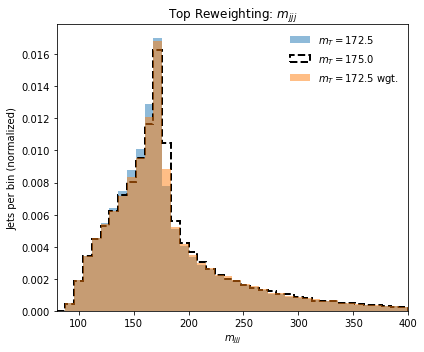

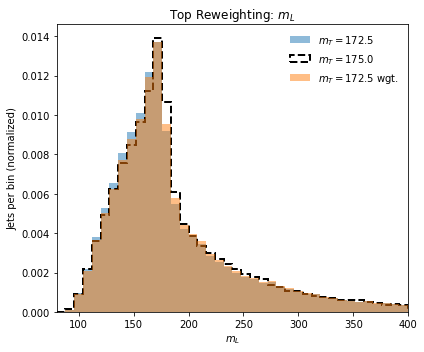

[0.9967093890750158, 0.9977135828304444]
Iteration:  2


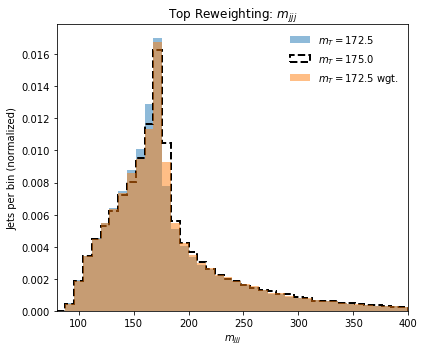

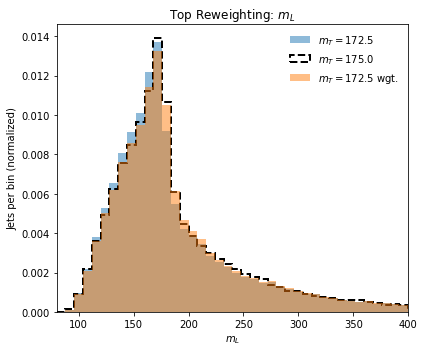

[0.9980114289152083, 0.9990980703044742]
Iteration:  3


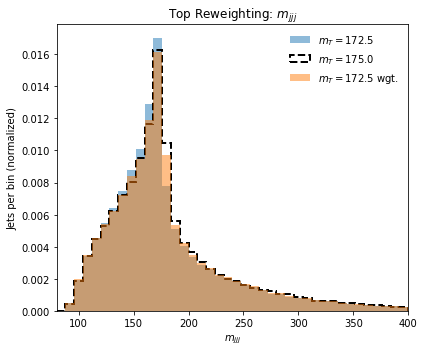

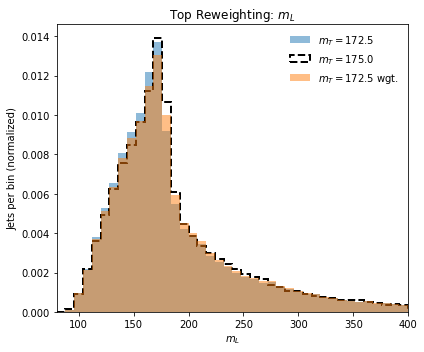

[0.9990996825440557, 0.9983316151085669]
Iteration:  4


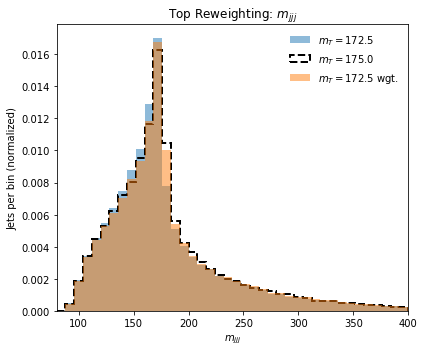

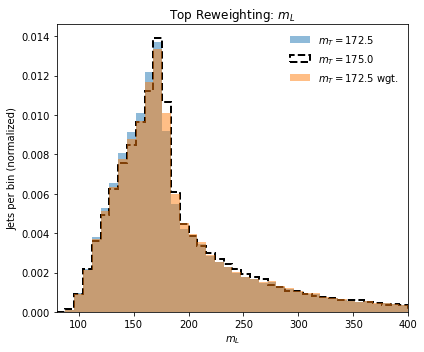

[0.9992484111266511, 0.9986951842616101]
Iteration:  5


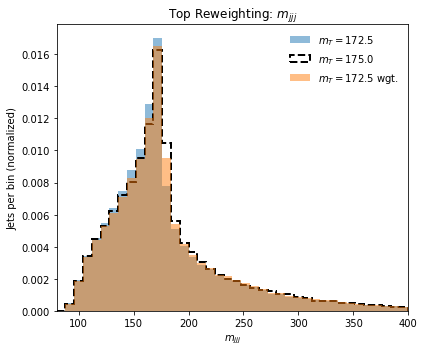

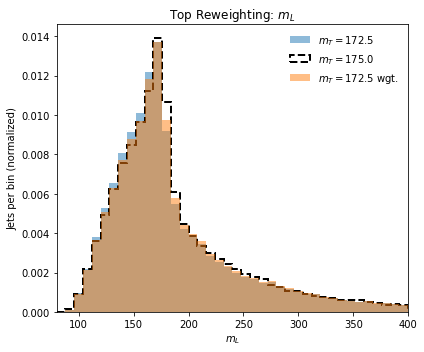

[0.9987116225888555, 0.9983439001096195]
Iteration:  6


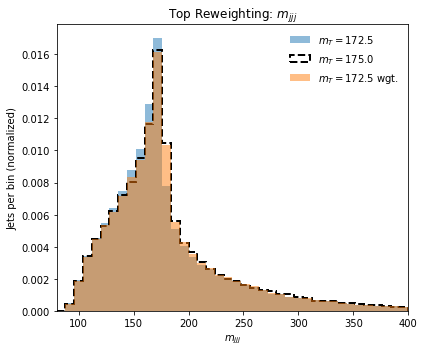

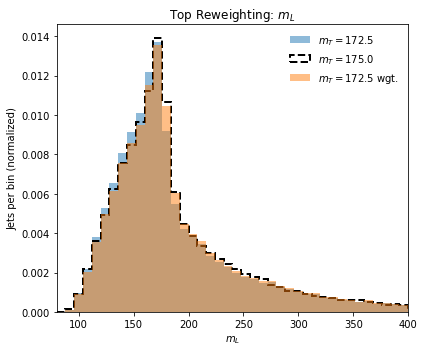

[0.9997465932315737, 0.9994683670353522]
Iteration:  7


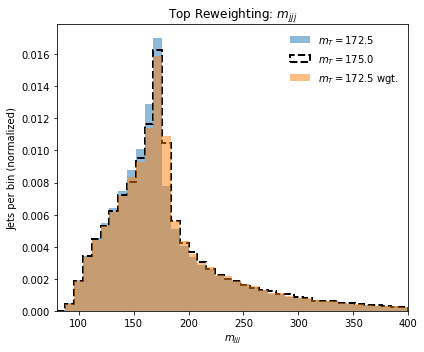

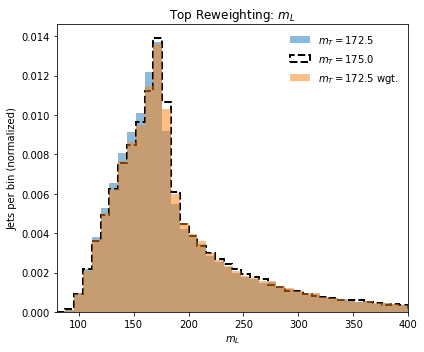

[0.9993916176979327, 0.9994058381602778]
Iteration:  8


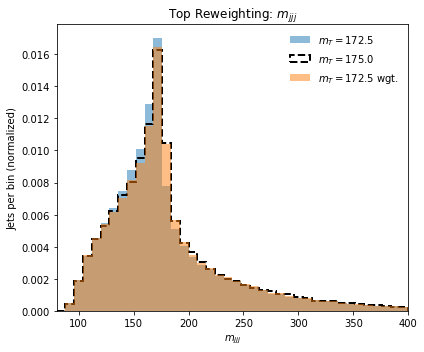

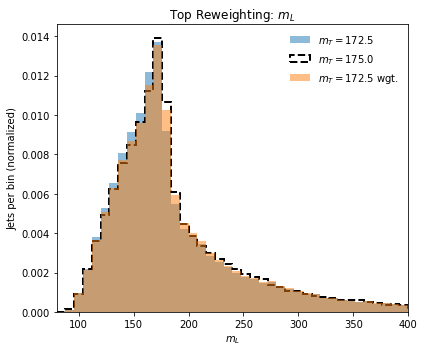

[0.999663381301147, 0.9992435572578345]
Iteration:  9


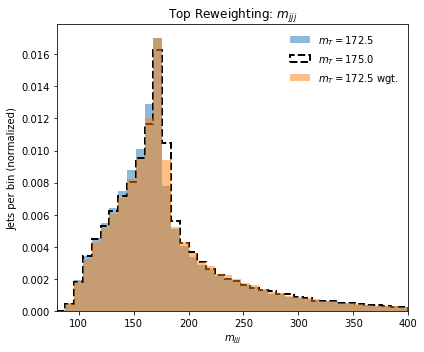

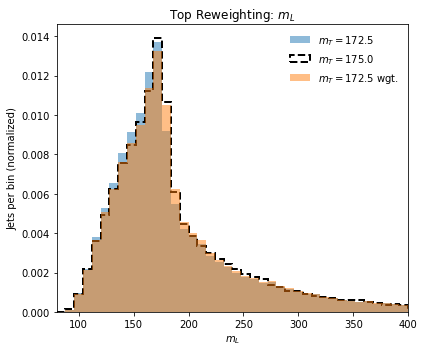

[0.9978447486100454, 0.999208879375415]
Iteration:  10


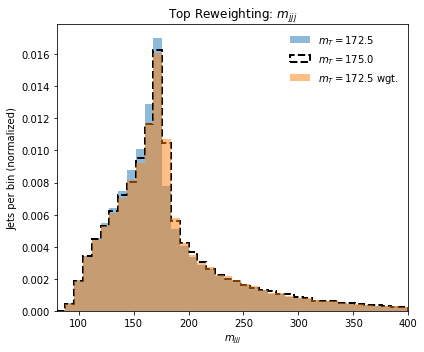

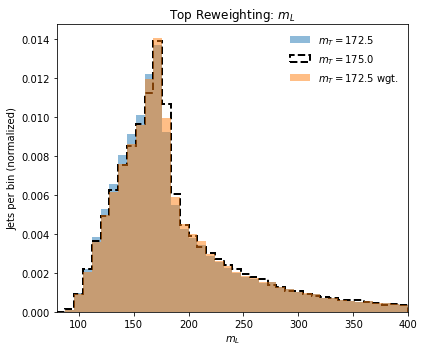

[0.9995883701027035, 0.9986554718787517]
Iteration:  11


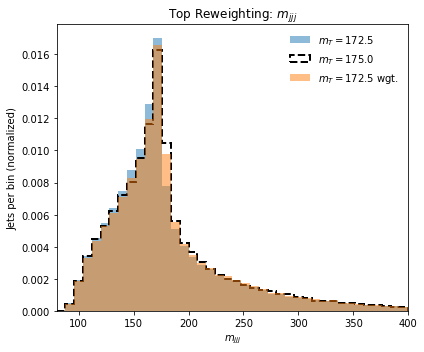

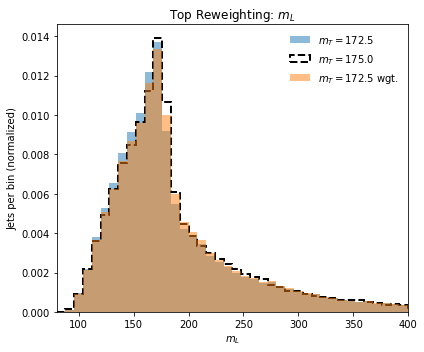

[0.9991188433519032, 0.9987575993501617]
Iteration:  12


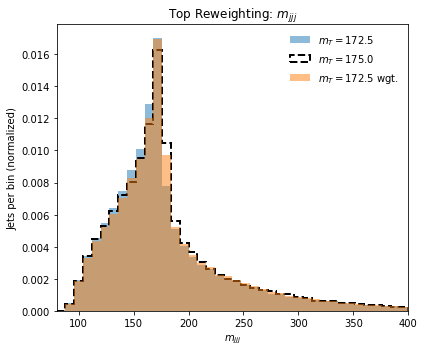

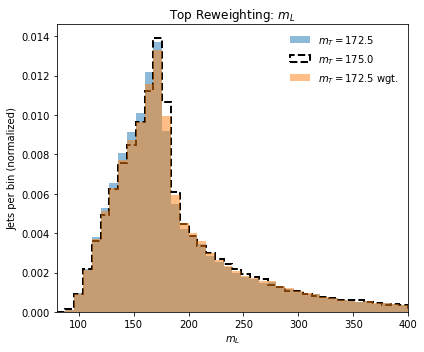

[0.998610252531164, 0.9986296692907707]
Iteration:  13


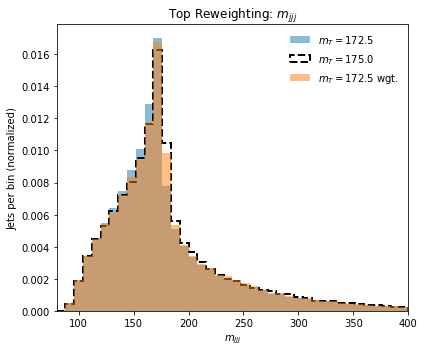

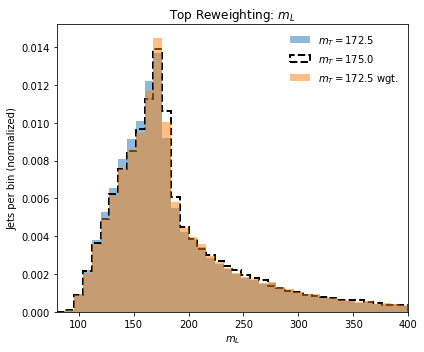

[0.9990344862515118, 0.9987562616889767]
Iteration:  14


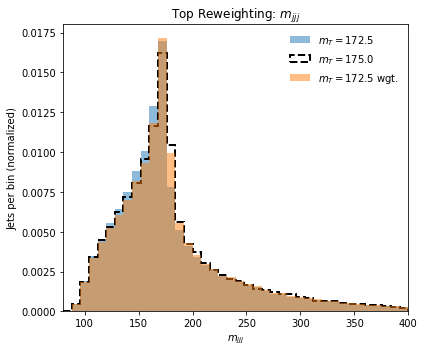

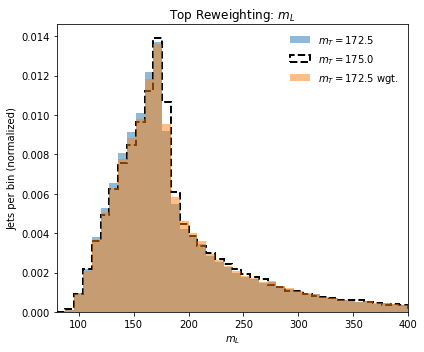

[0.9986890252097229, 0.9977225307730618]
Iteration:  15


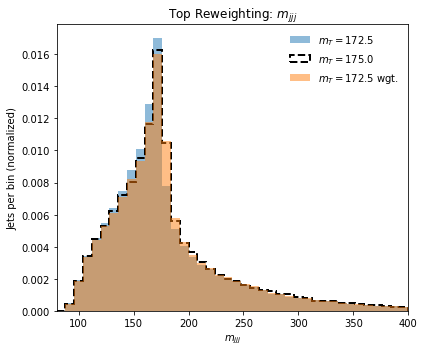

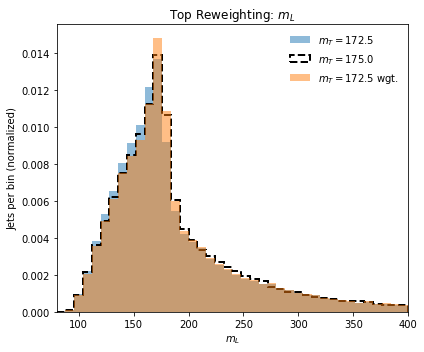

[0.9996096498063649, 0.9988363555774409]
Iteration:  16


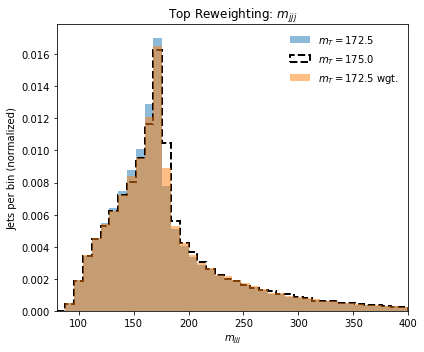

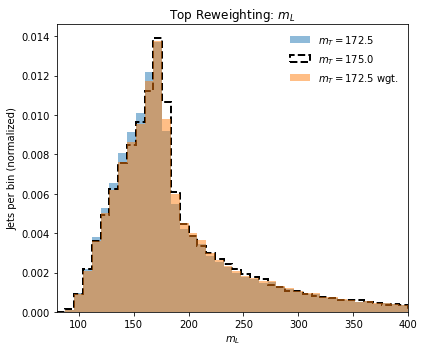

[0.997200262384707, 0.9986241504961939]
Iteration:  17


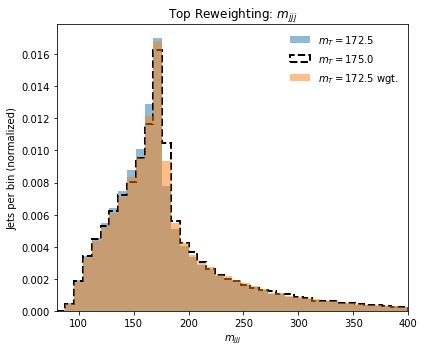

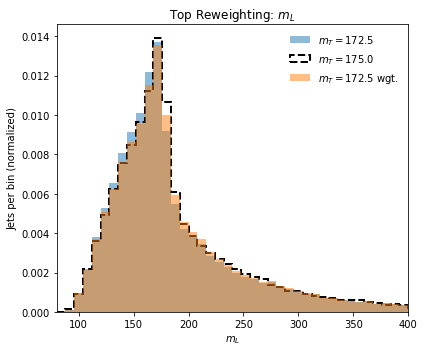

[0.9981022923469954, 0.9989868351584774]
Iteration:  18


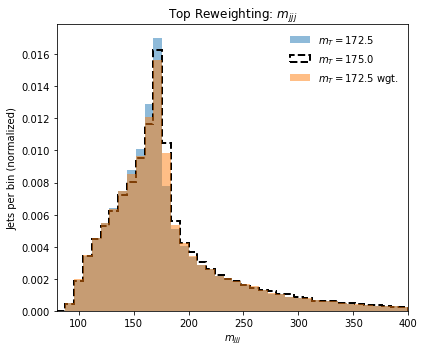

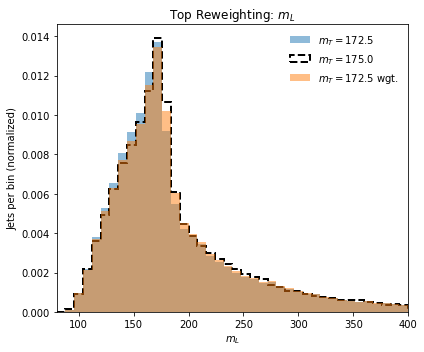

[0.9986068644671923, 0.9991656212512122]
Iteration:  19


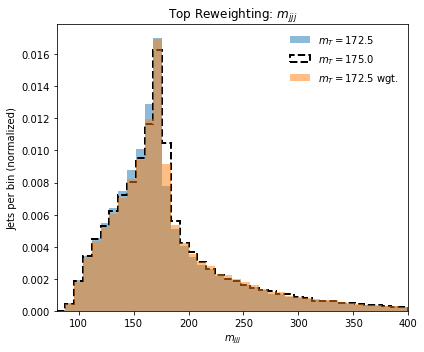

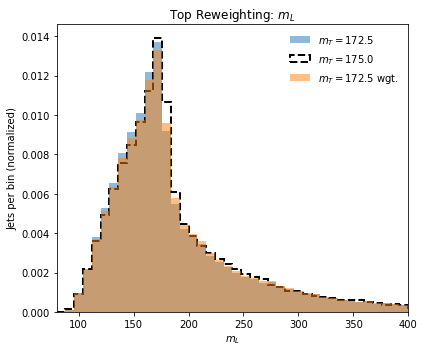

[0.9974979787317579, 0.9976066533025555]
Iteration:  20


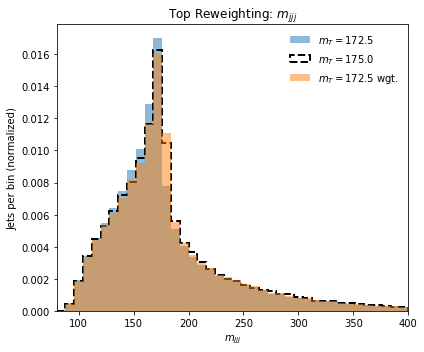

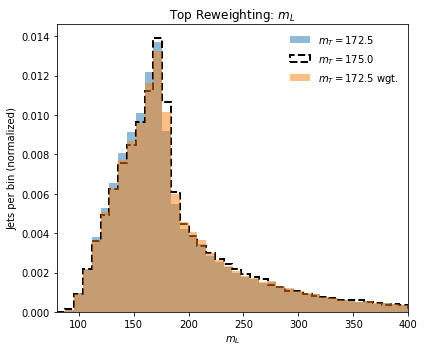

[0.9992924038257855, 0.9987786239287318]
Iteration:  21


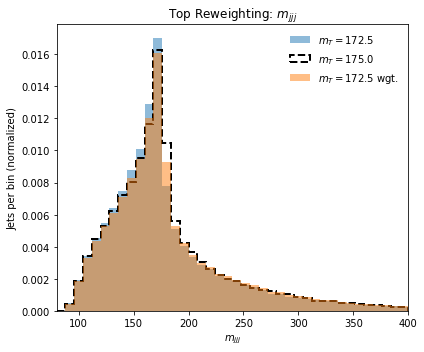

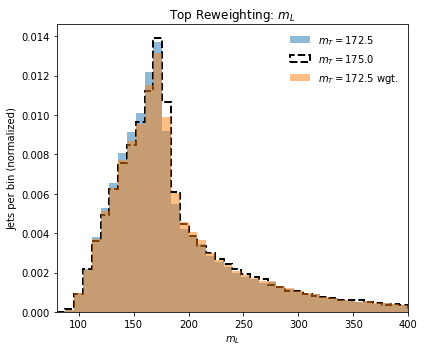

[0.9983016148111703, 0.99838161552438]
Iteration:  22


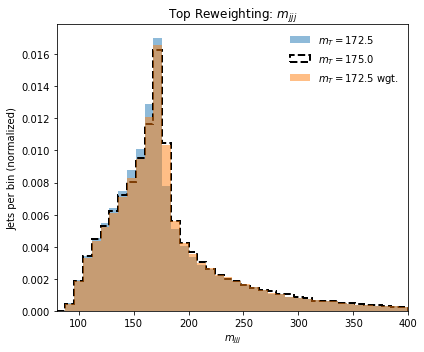

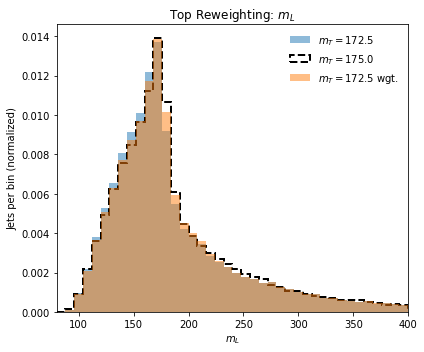

[0.9995870995857334, 0.9990551519874519]
Iteration:  23


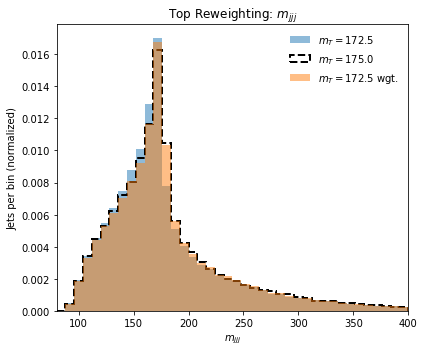

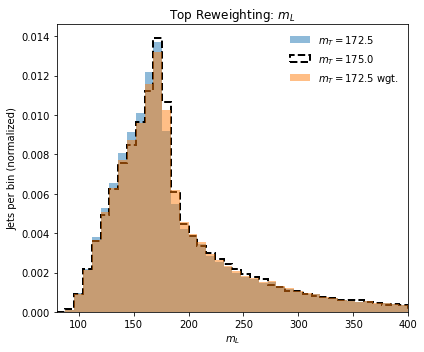

[0.9995127001486858, 0.9988786502646689]
Iteration:  24


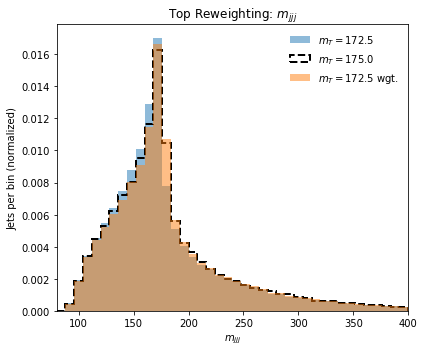

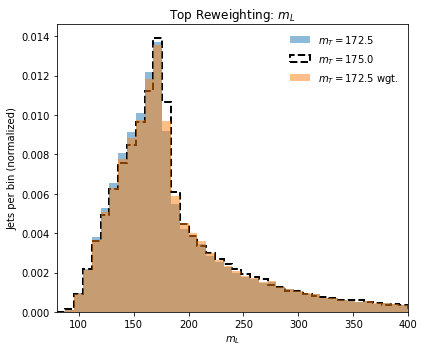

[0.9993498856573771, 0.998095313922815]
Iteration:  25


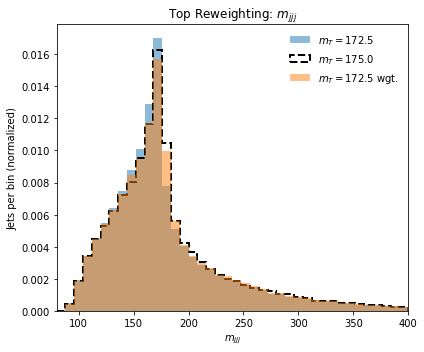

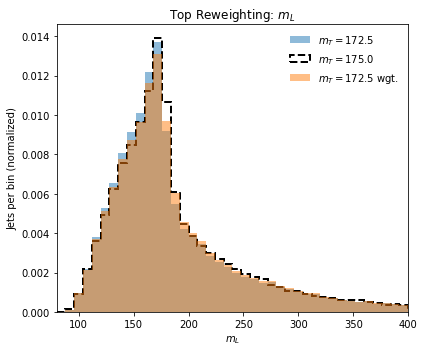

[0.9992479025735936, 0.9979110338107373]
Iteration:  26


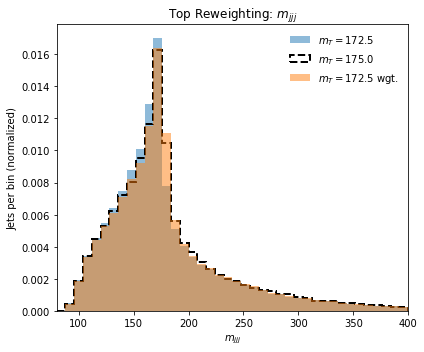

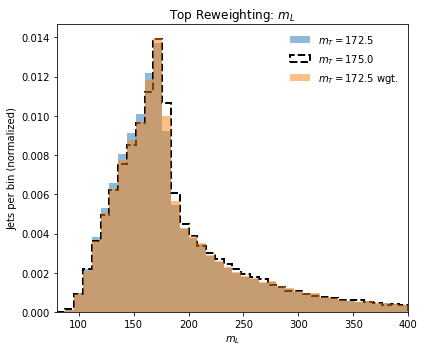

[0.9993083811379628, 0.998619923211322]
Iteration:  27


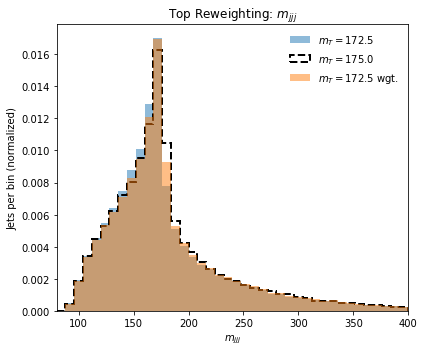

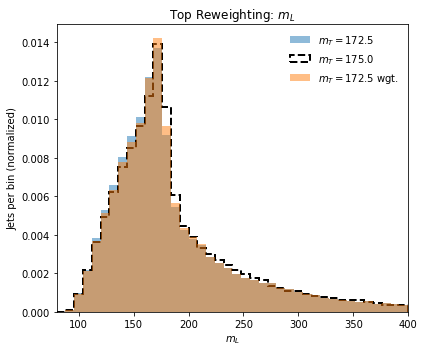

[0.9978733817466172, 0.9974809407748304]
Iteration:  28


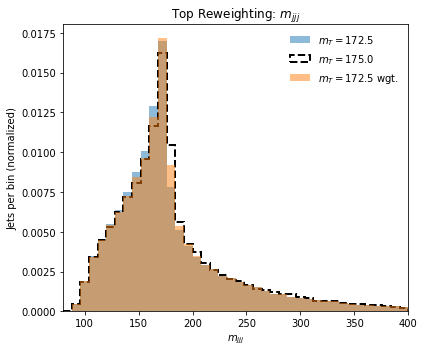

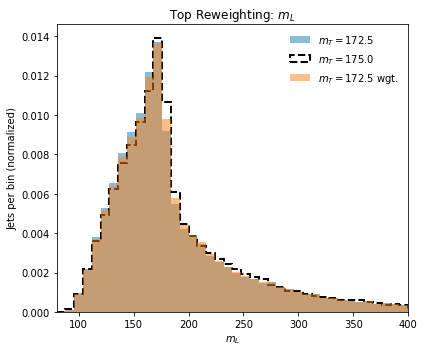

[0.9973266290477505, 0.9979870127853849]
Iteration:  29


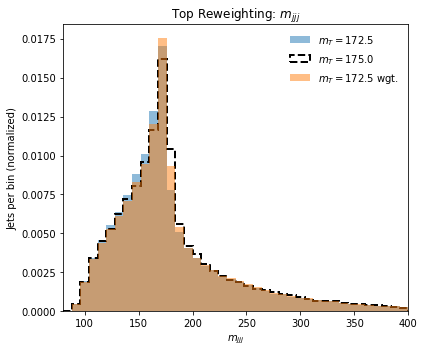

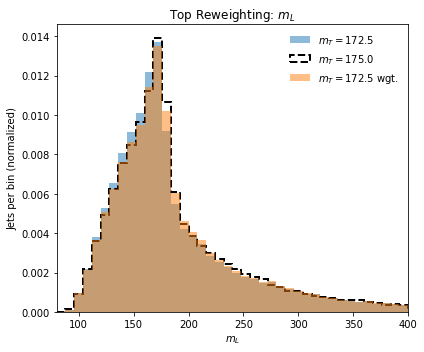

[0.9970161545852685, 0.9992520205510496]
Iteration:  30


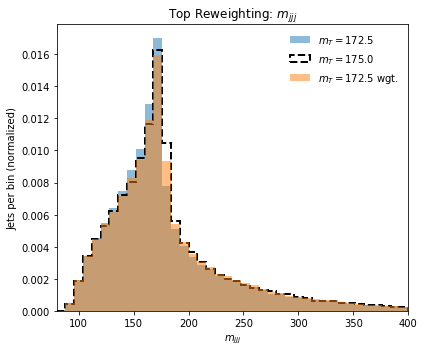

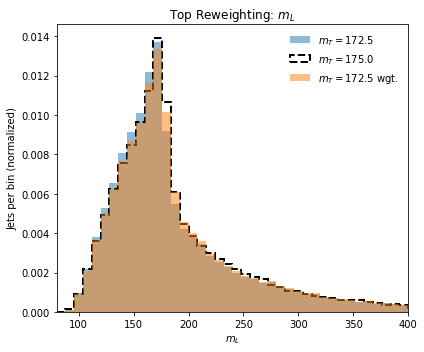

[0.998661447190958, 0.9989661041650447]
Iteration:  31


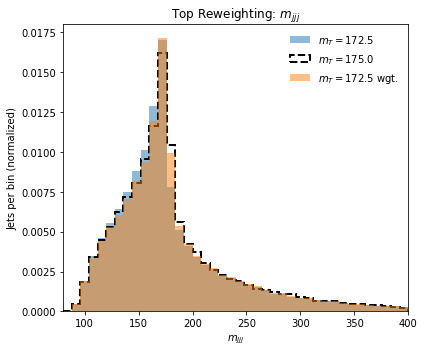

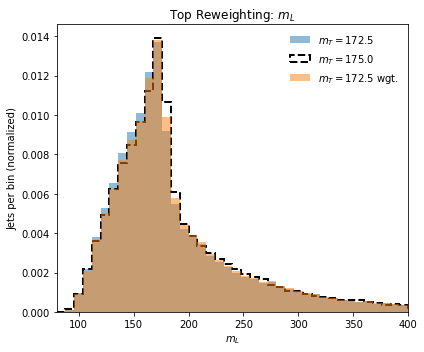

[0.998735977530761, 0.9985944662378822]
Iteration:  32


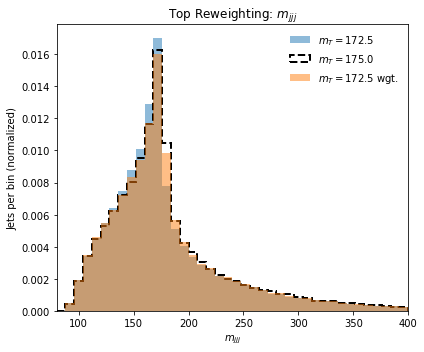

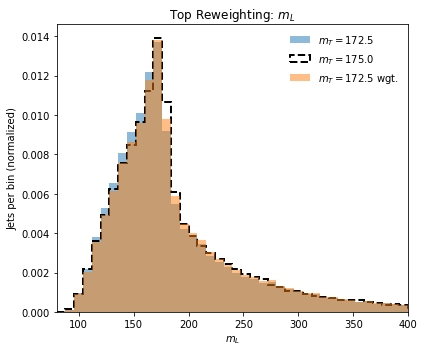

[0.9993132970581792, 0.9985889607494113]
Iteration:  33


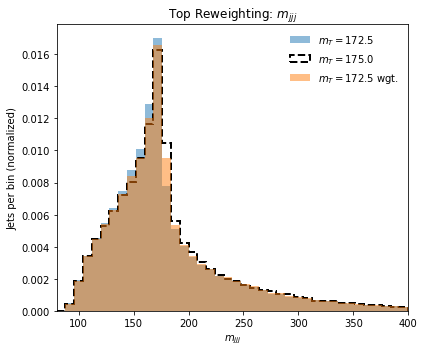

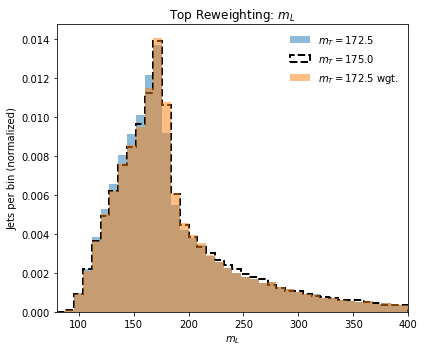

[0.9986160945835417, 0.9996353429346818]
Iteration:  34


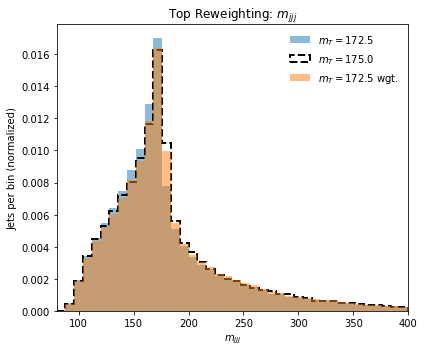

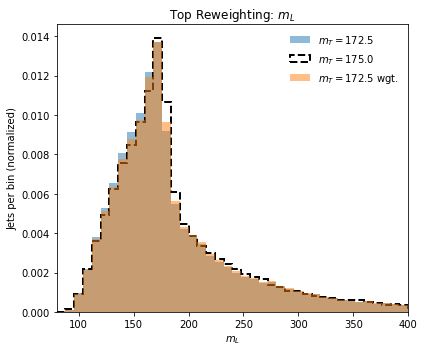

[0.9994119206881793, 0.9977215008106687]
Iteration:  35


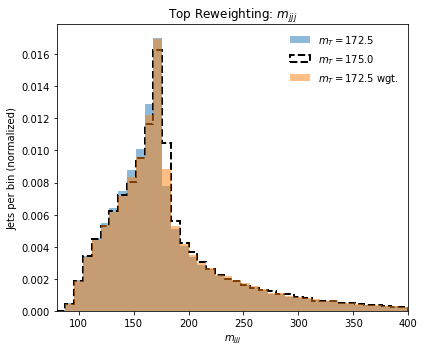

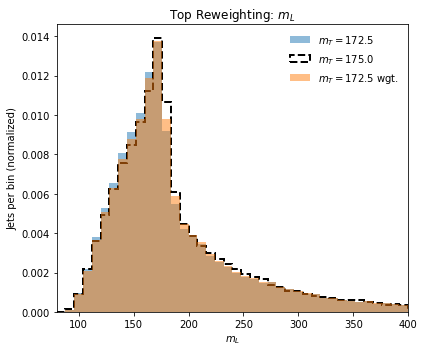

[0.9966430217627974, 0.9983088014987336]
Iteration:  36


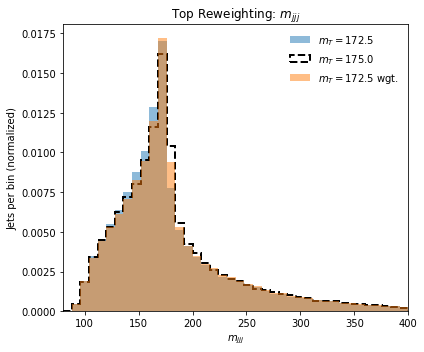

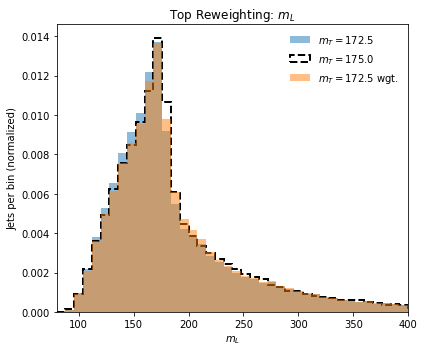

[0.9976748863320797, 0.9984769702200215]
Iteration:  37


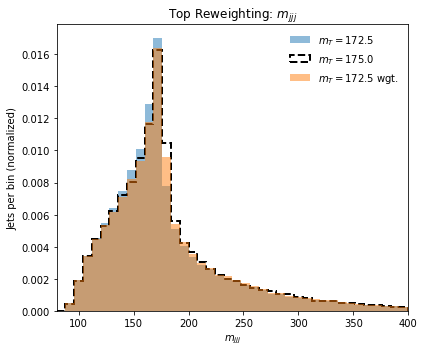

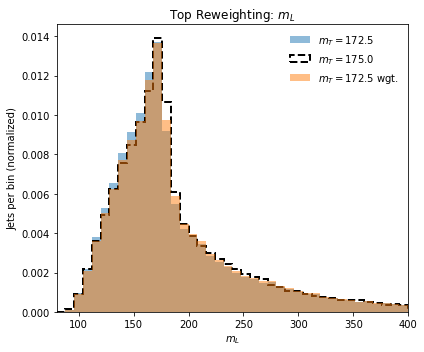

[0.9990820665210116, 0.9983644912193579]
Iteration:  38


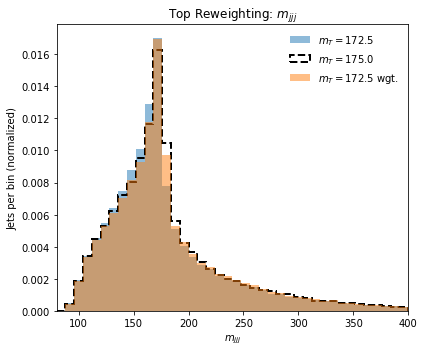

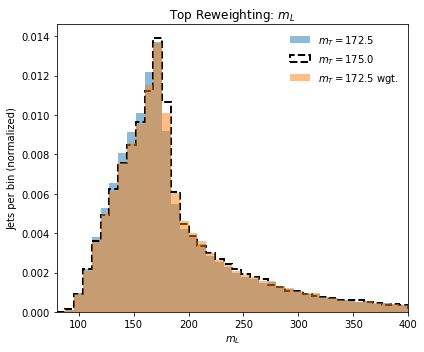

[0.9986786713419359, 0.9992524556906703]
Iteration:  39


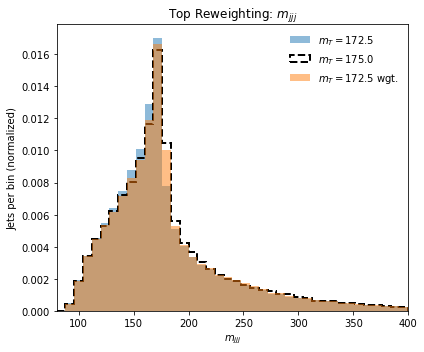

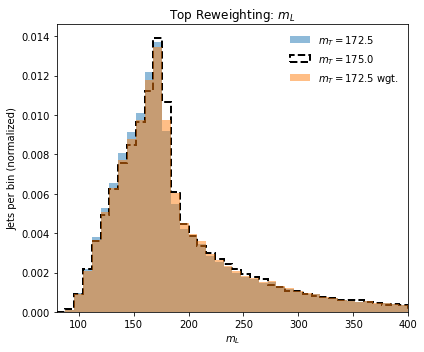

[0.9992658494470587, 0.998271116367753]
Iteration:  40


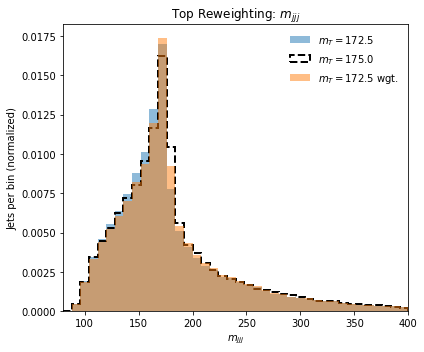

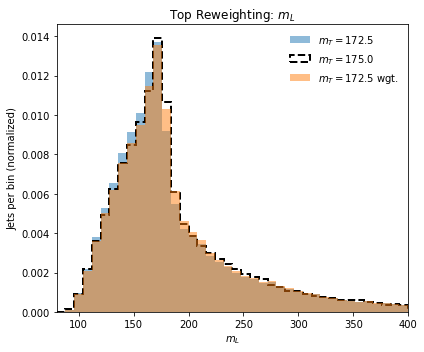

[0.9970770646962063, 0.9993348735447046]
Iteration:  41


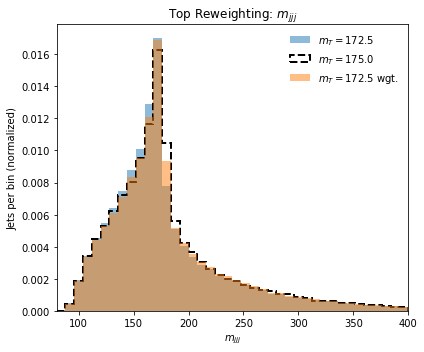

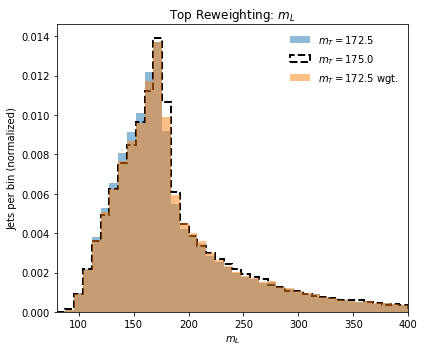

[0.9979397059088034, 0.9987708717909298]
Iteration:  42


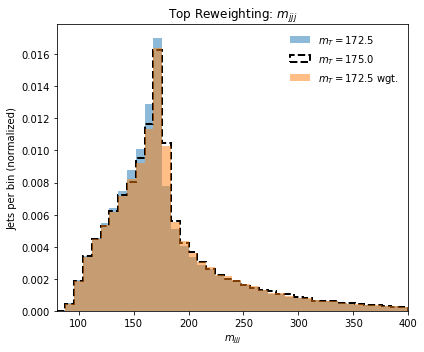

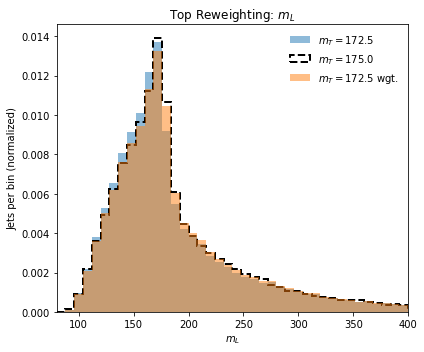

[0.9996003300817056, 0.9992891847889804]
Iteration:  43


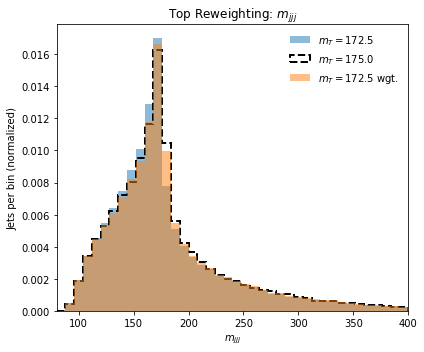

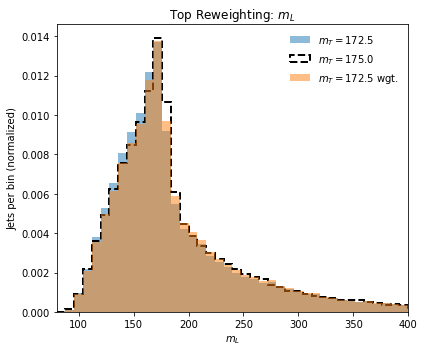

[0.9993744786330134, 0.9983414186396213]
Iteration:  44


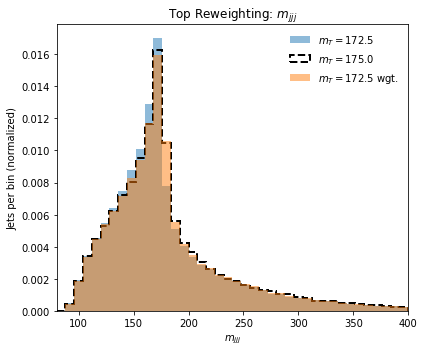

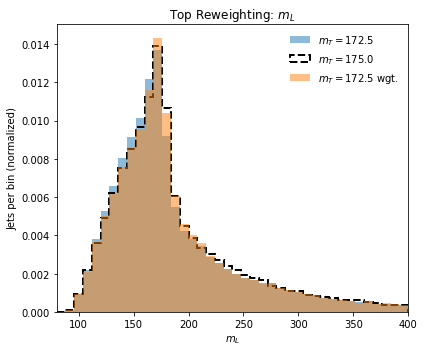

[0.9996467848078464, 0.9993349656145154]
Iteration:  45


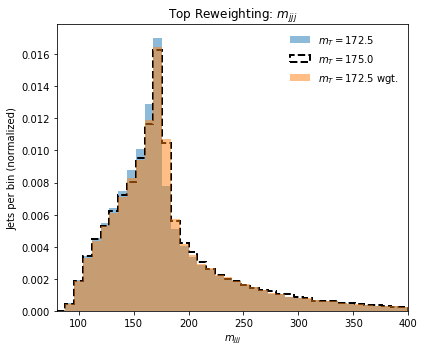

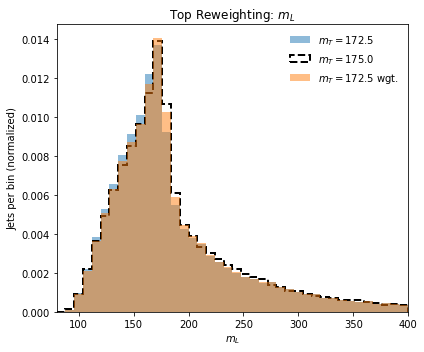

[0.9996342583199598, 0.999268253663427]
Iteration:  46


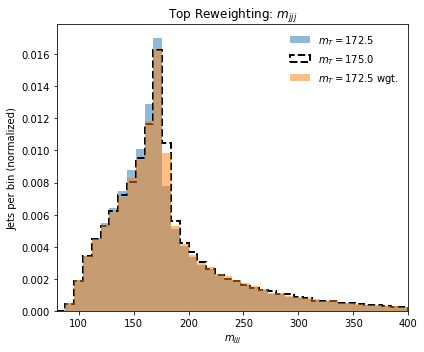

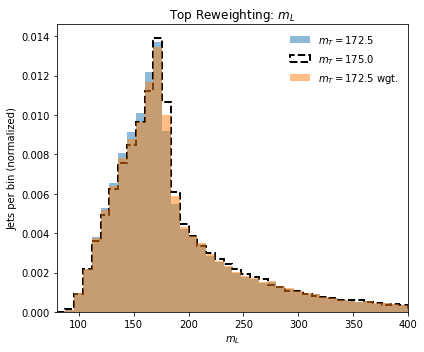

[0.9993217120196879, 0.9985972383939612]
Iteration:  47


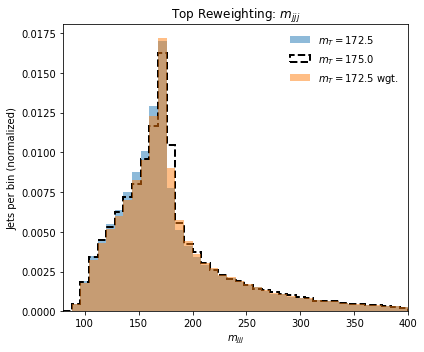

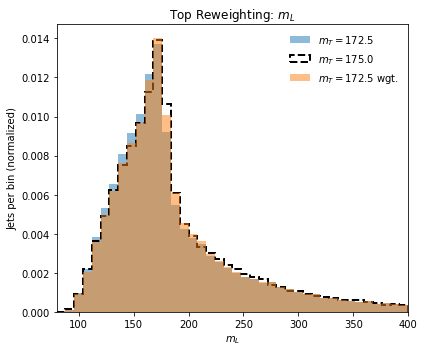

[0.9966288699212147, 0.9989346828750894]
Iteration:  48


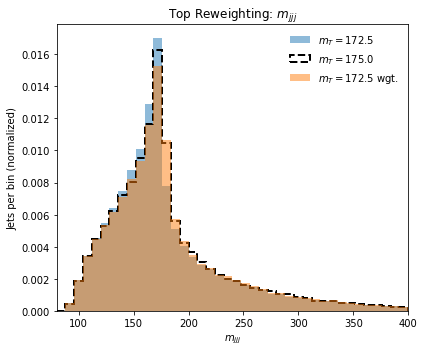

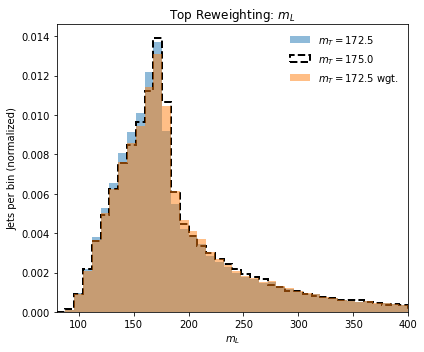

[0.9990526813071428, 0.9988835213244954]
Iteration:  49


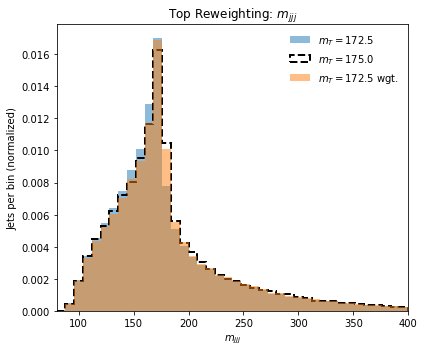

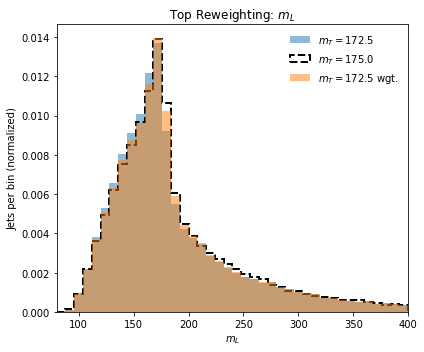

[0.9992479194344281, 0.9992407559007276]
Iteration:  50


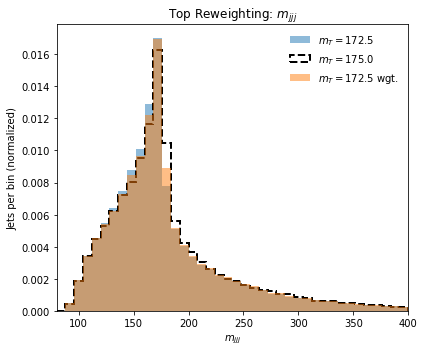

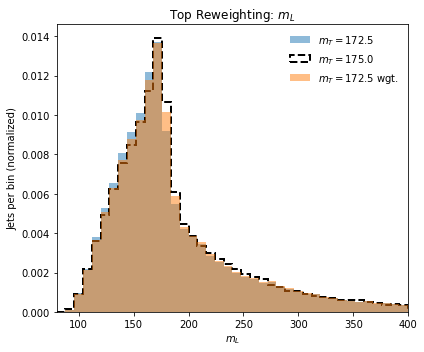

[0.9965926146438583, 0.9988910638090204]
Iteration:  51


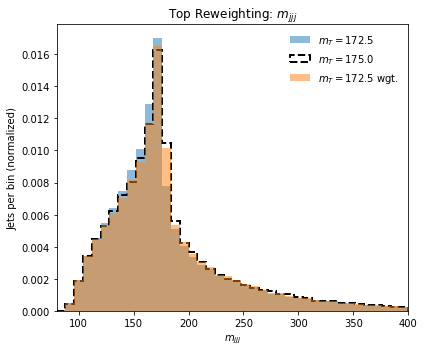

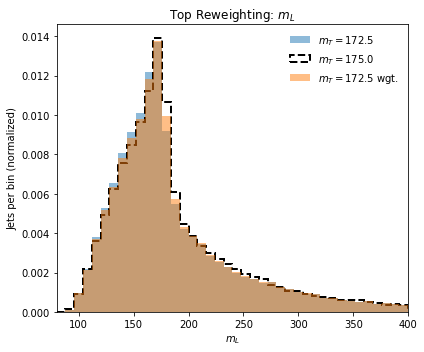

[0.9995504461291334, 0.99843387201156]
Iteration:  52


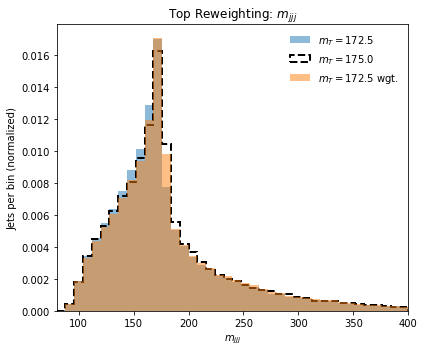

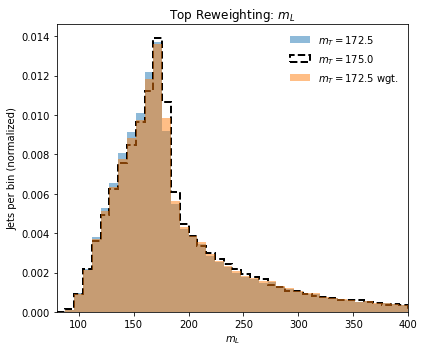

[0.9984035975101513, 0.998190601707401]
Iteration:  53


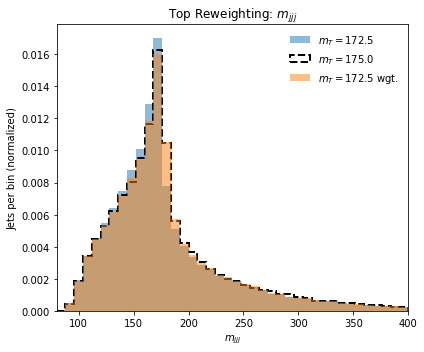

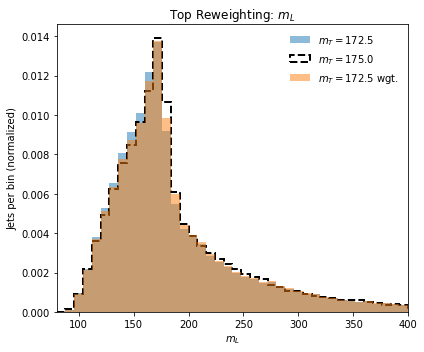

[0.9996763683001736, 0.998652107224237]
Iteration:  54


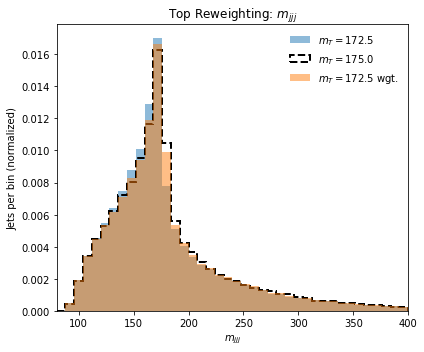

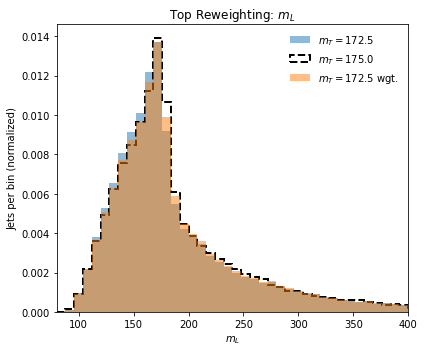

[0.9992461897872377, 0.9987886818865513]
Iteration:  55


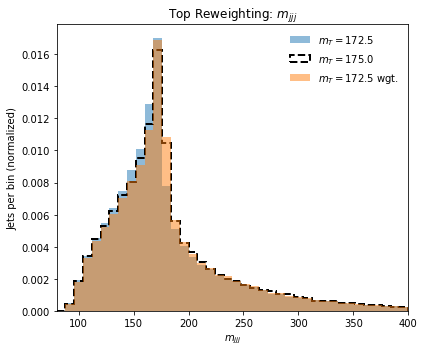

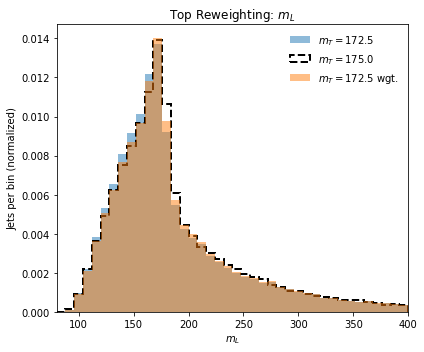

[0.998945496203093, 0.998400556837547]
Iteration:  56


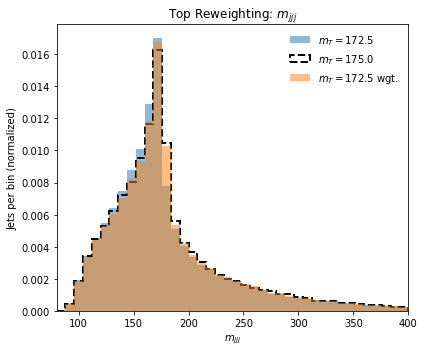

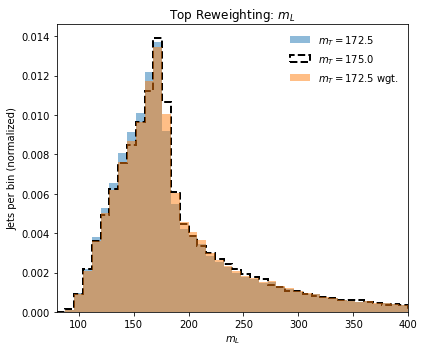

[0.9993981147050217, 0.9988271333237644]
Iteration:  57


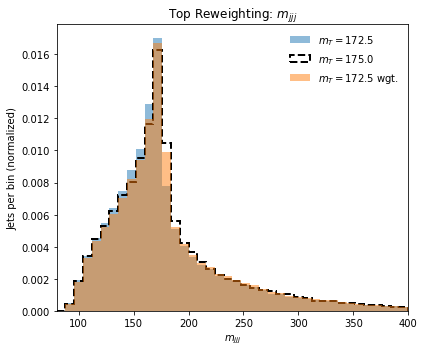

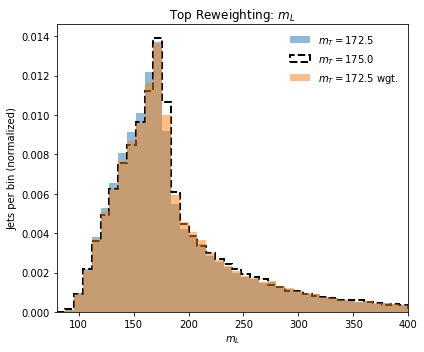

[0.9989651638647028, 0.9989204030406162]
Iteration:  58


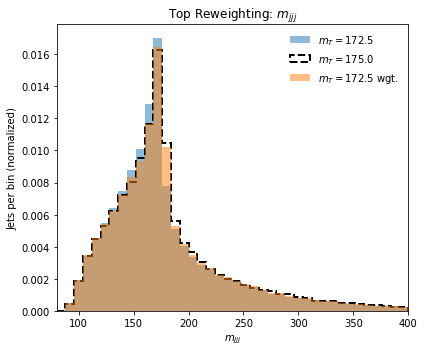

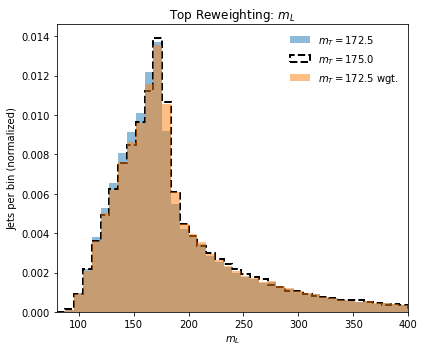

[0.9995750833742727, 0.9994251247420115]
Iteration:  59


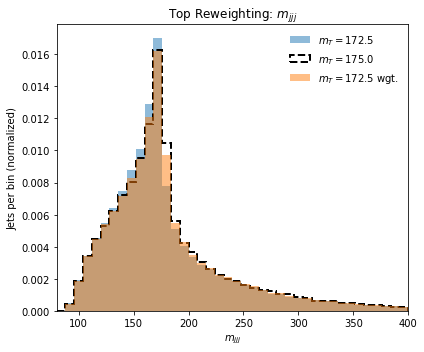

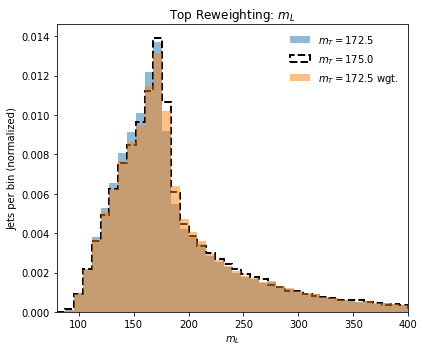

[0.9991199129444, 0.9986985536406969]
Iteration:  60


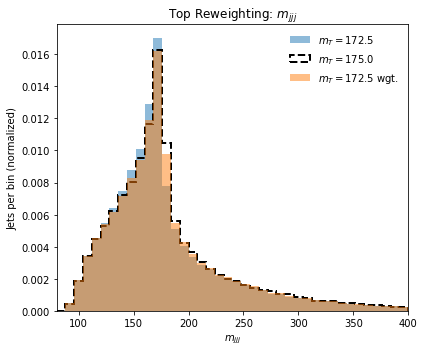

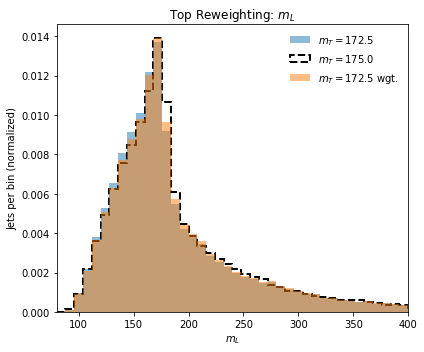

[0.9993447953020599, 0.9978402844514342]
Iteration:  61


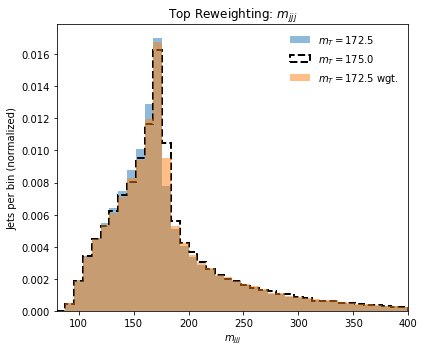

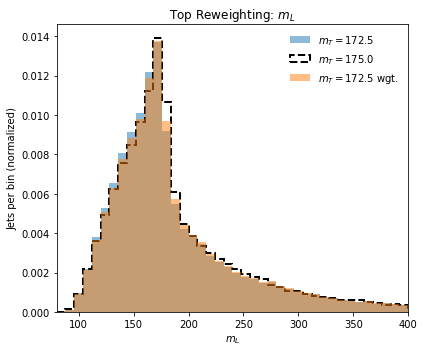

[0.9985572691652529, 0.9979355379067398]
Iteration:  62


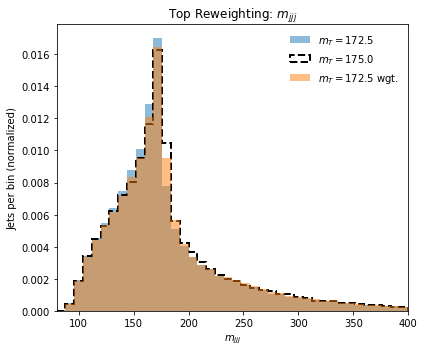

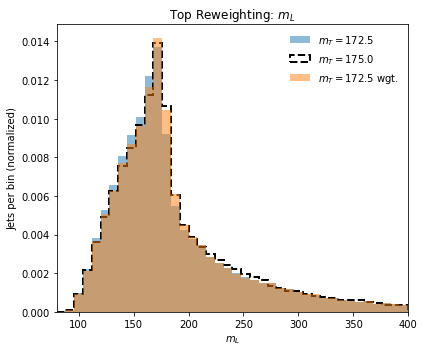

[0.9986147016602286, 0.9994610059920624]
Iteration:  63


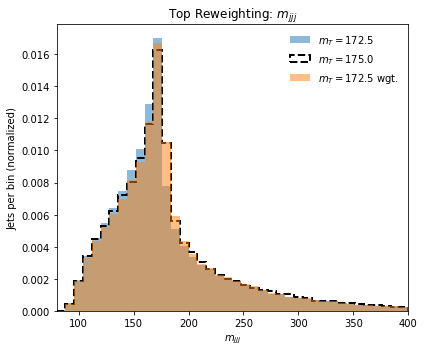

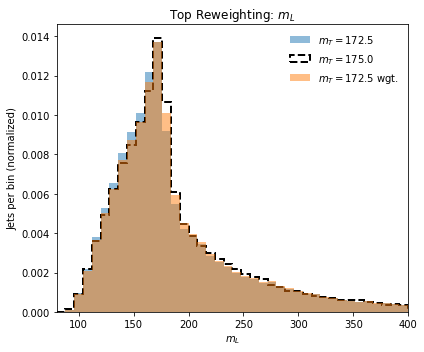

[0.999442047713842, 0.9990559818104978]
Iteration:  64


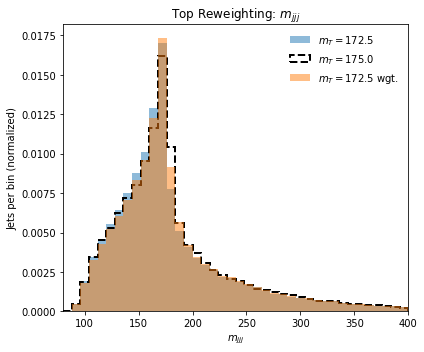

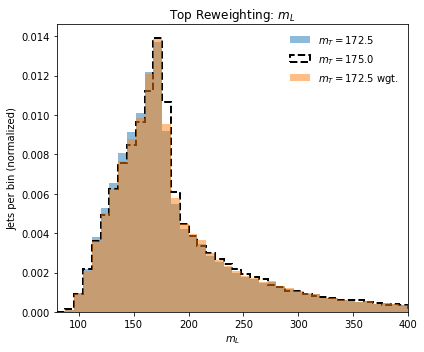

[0.9968954573494869, 0.997467522514362]
Iteration:  65


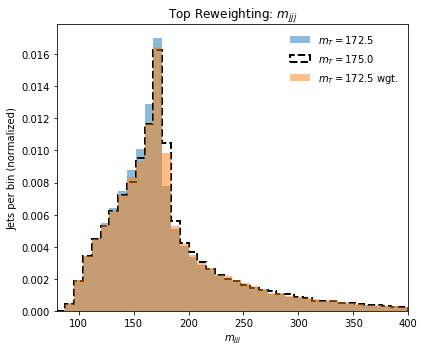

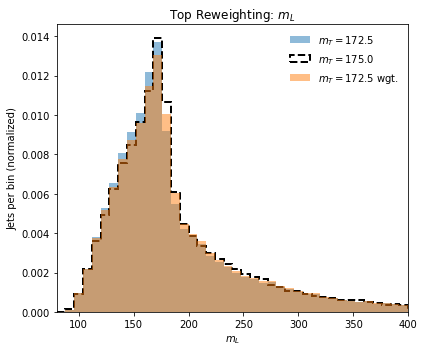

[0.9992150286231103, 0.9984799731108107]
Iteration:  66


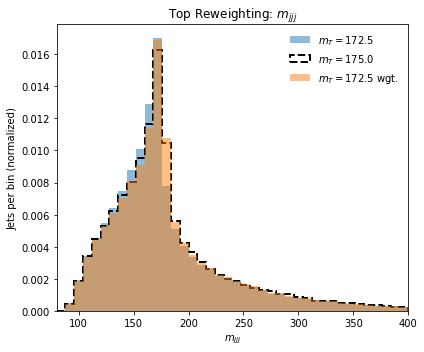

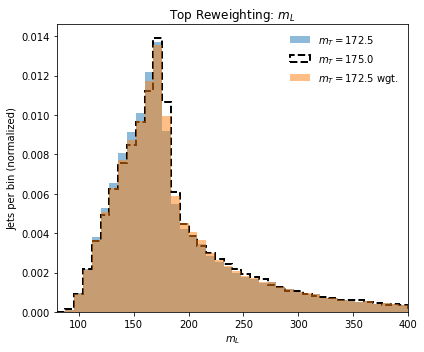

[0.9991225723780897, 0.9986490334495076]
Iteration:  67


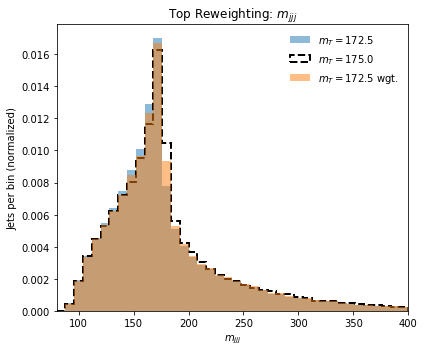

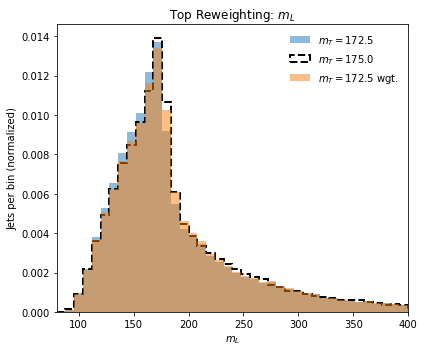

[0.998014466000444, 0.9990252954771145]
Iteration:  68


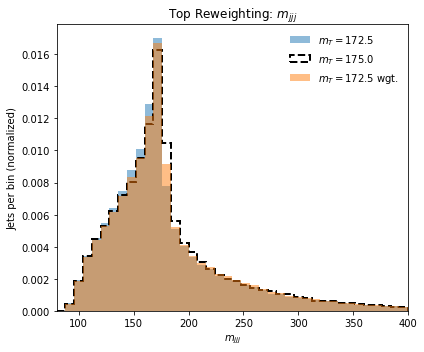

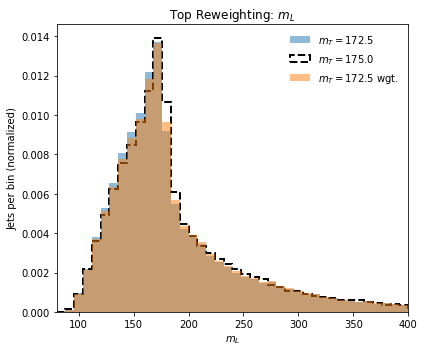

[0.9975539461230829, 0.9978830988565023]
Iteration:  69


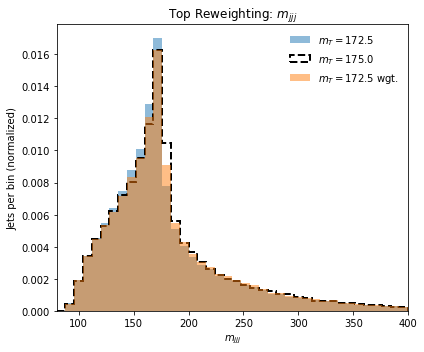

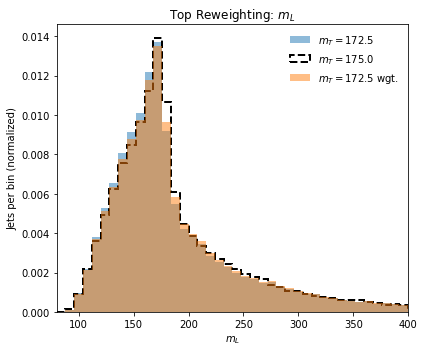

[0.9979745999997441, 0.9980388999210387]
Iteration:  70


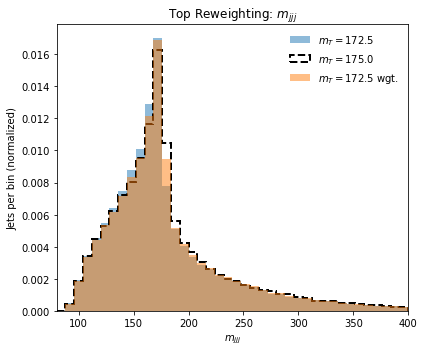

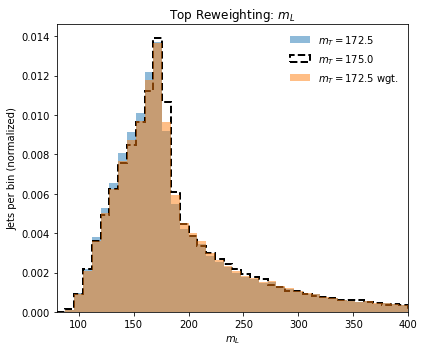

[0.998176025971758, 0.9982509885261798]
Iteration:  71


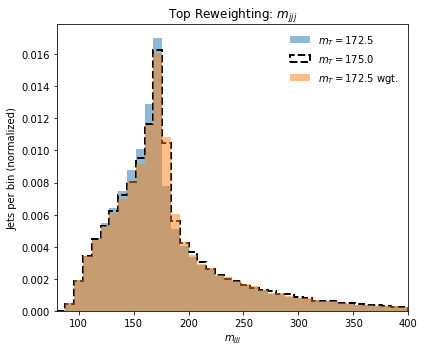

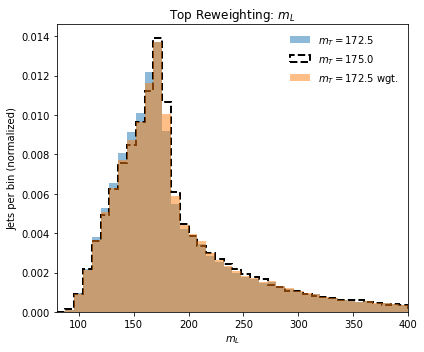

[0.9992486731147755, 0.9990467938516159]
Iteration:  72


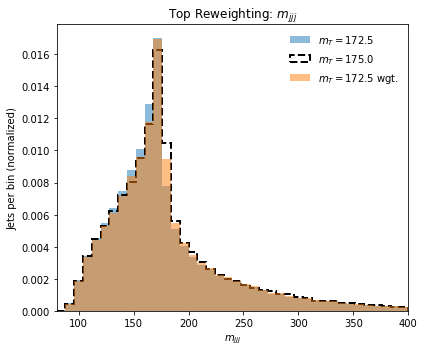

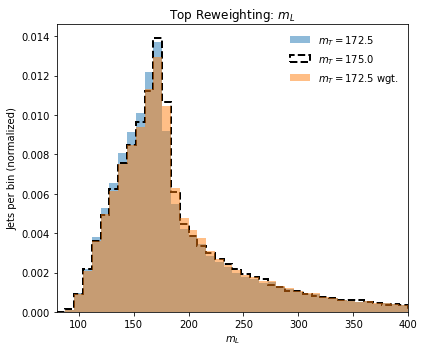

[0.9984122835989411, 0.9985534519304643]
Iteration:  73


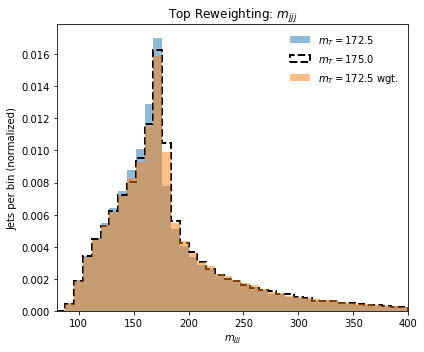

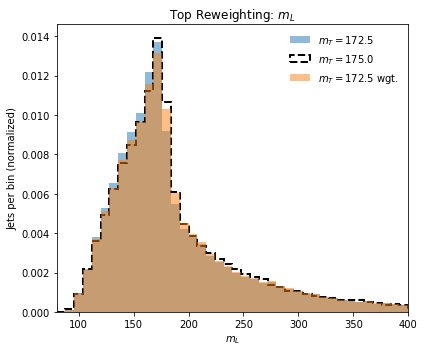

[0.9995150971743327, 0.998755794679141]
Iteration:  74


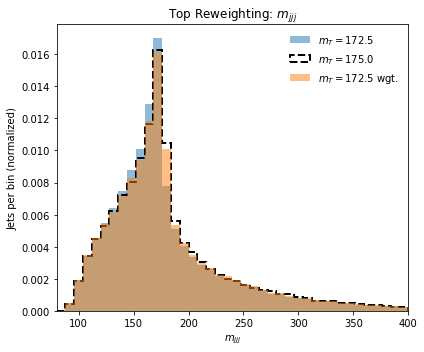

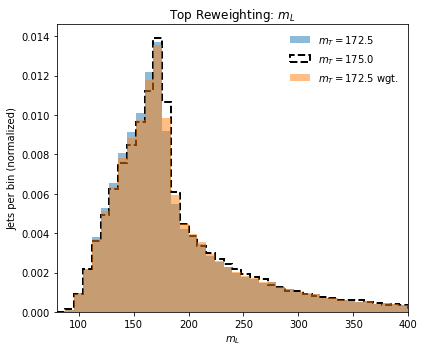

[0.9995526205105641, 0.9983153229717782]
Iteration:  75


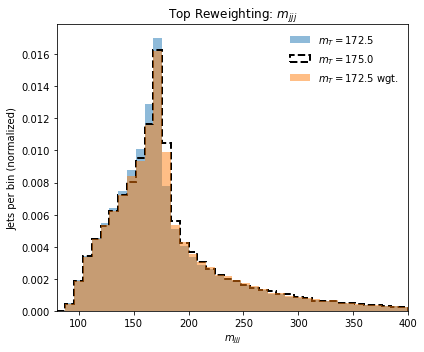

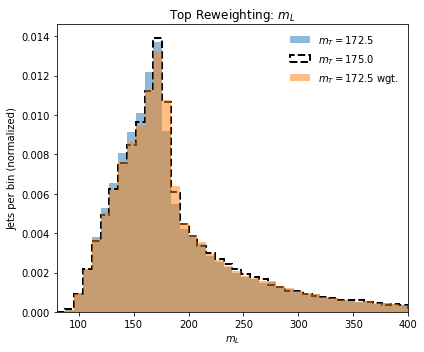

[0.9994703302816945, 0.9991381623440623]
Iteration:  76


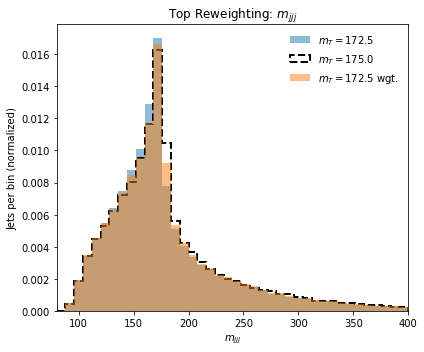

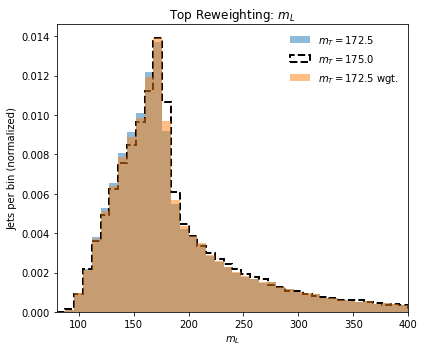

[0.9980551156743899, 0.9978594576812697]
Iteration:  77


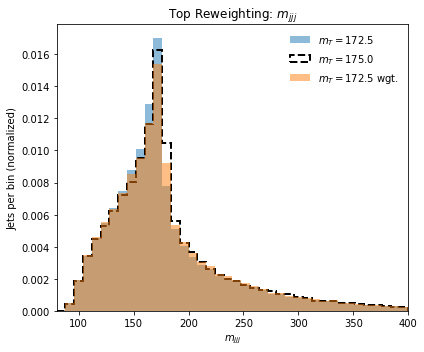

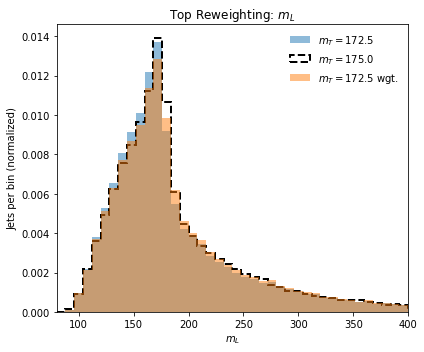

[0.997752358033626, 0.9981040706437928]
Iteration:  78


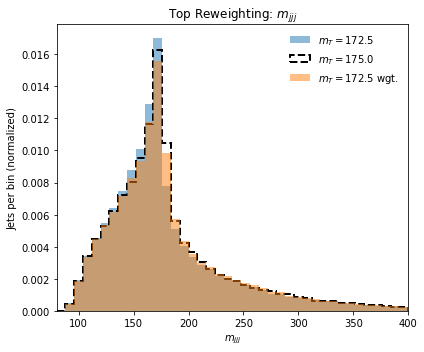

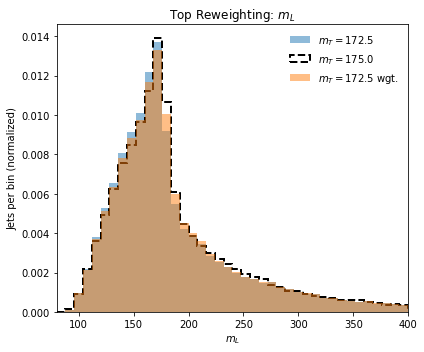

[0.9992015453905843, 0.9984033856120588]
Iteration:  79


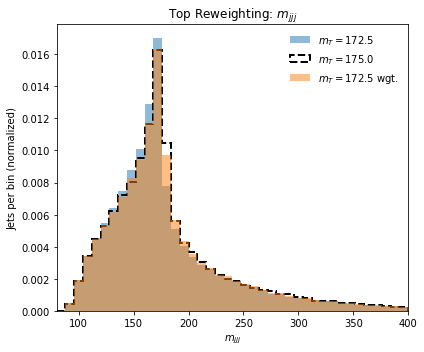

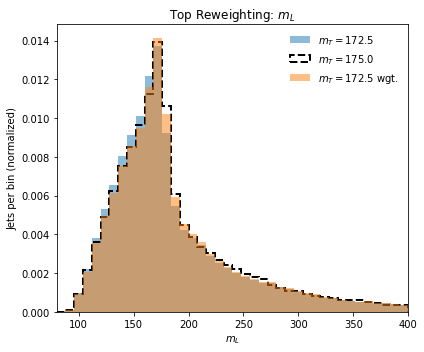

[0.9992790447234795, 0.9992615591089206]
Iteration:  80


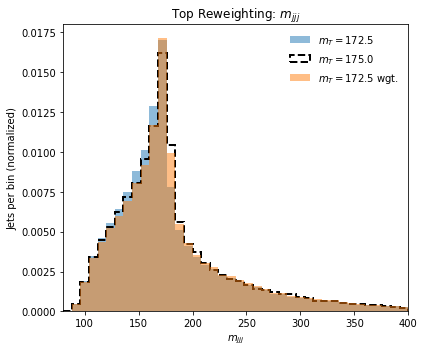

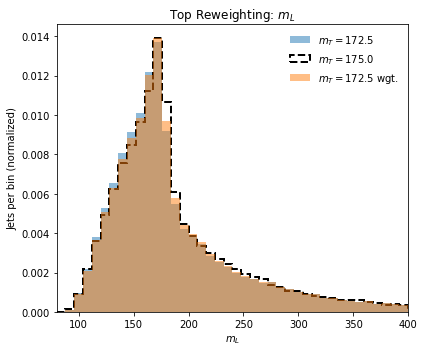

[0.9984916273668415, 0.9979532369532239]
Iteration:  81


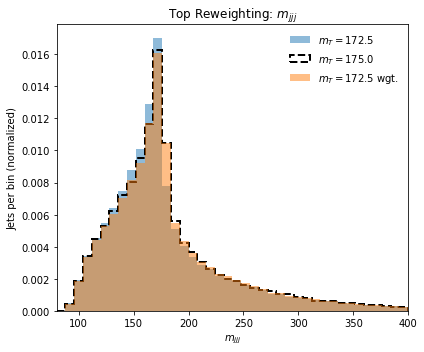

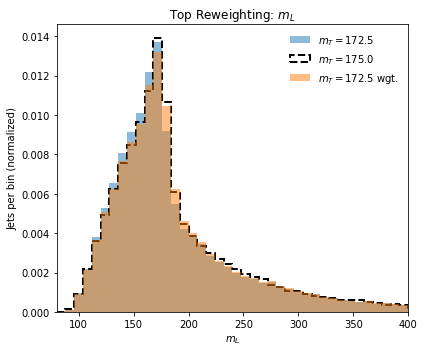

[0.9997029177205866, 0.9990026665735249]
Iteration:  82


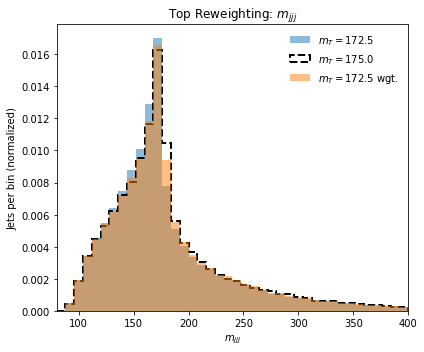

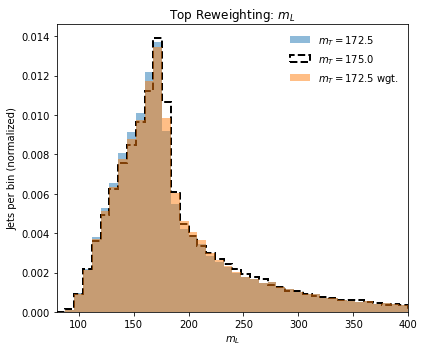

[0.9985516108950487, 0.9982735272142348]
Iteration:  83


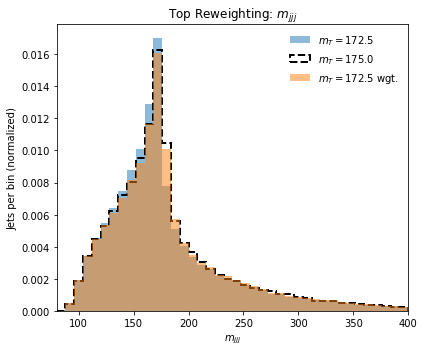

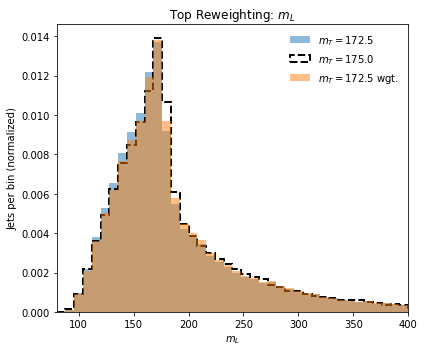

[0.9996474079882228, 0.9980854818246948]
Iteration:  84


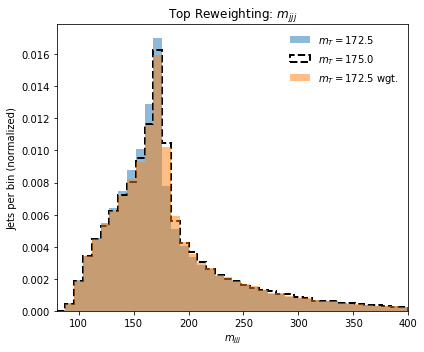

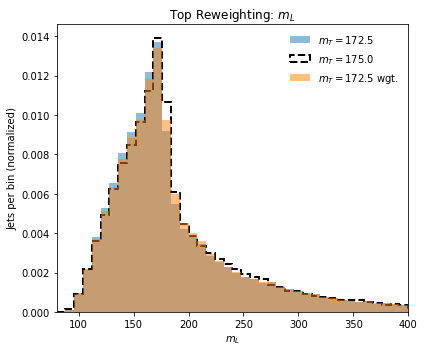

[0.9995474471115784, 0.9980255546836934]
Iteration:  85


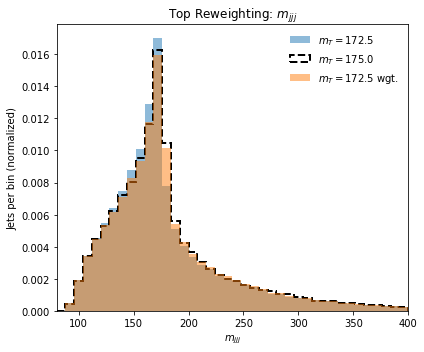

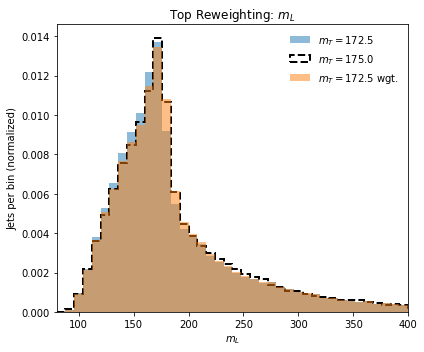

[0.9996379432143617, 0.9993653222322832]
Iteration:  86


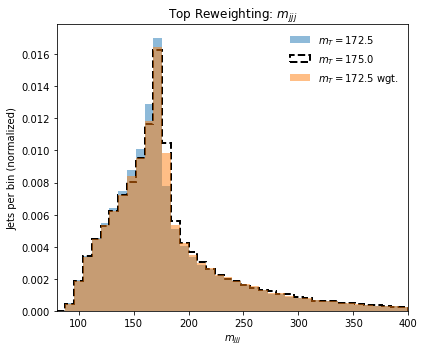

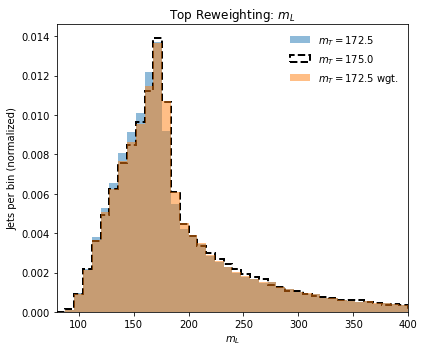

[0.9993279359126751, 0.9995219961770366]
Iteration:  87


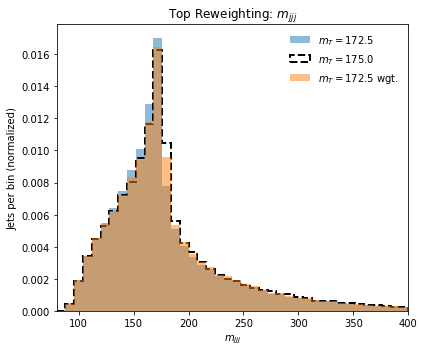

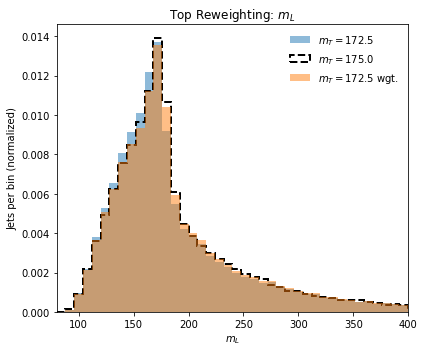

[0.9989554077647993, 0.9995257762963504]
Iteration:  88


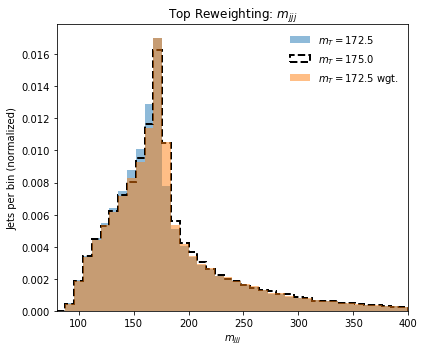

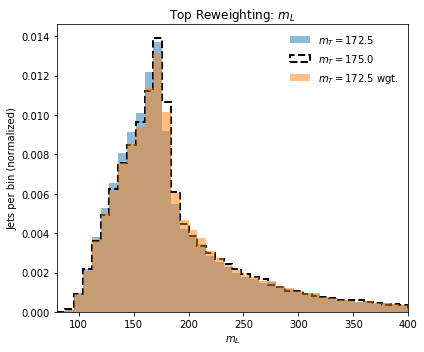

[0.9991603827022438, 0.9988713035338623]
Iteration:  89


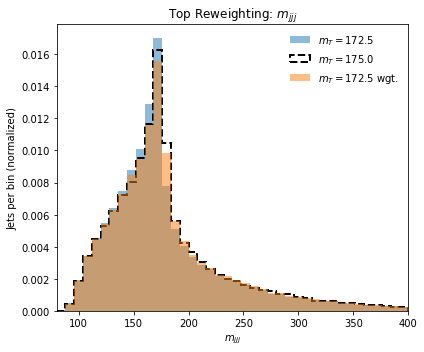

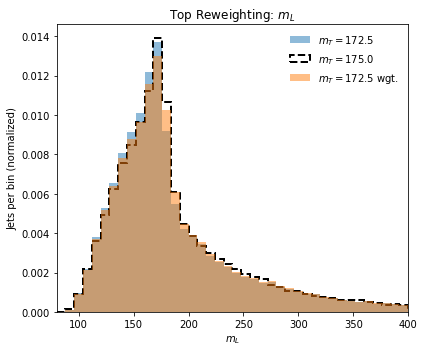

[0.999067429654939, 0.9983511772411375]
Iteration:  90


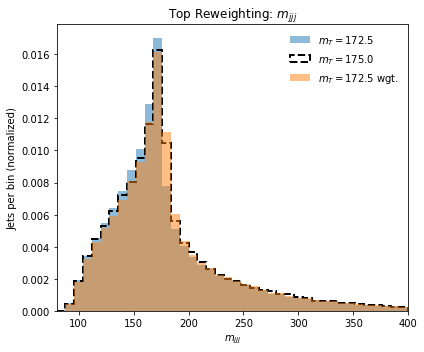

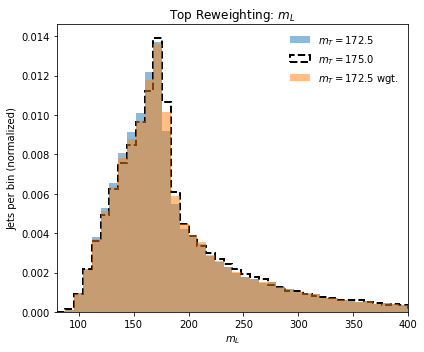

[0.9988916230020832, 0.9988543456383717]
Iteration:  91


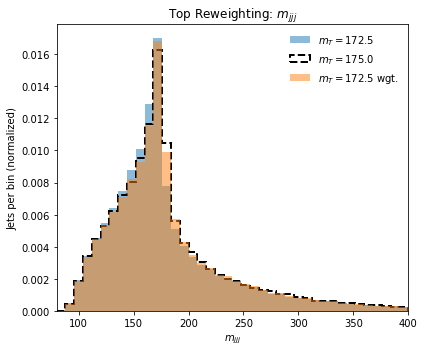

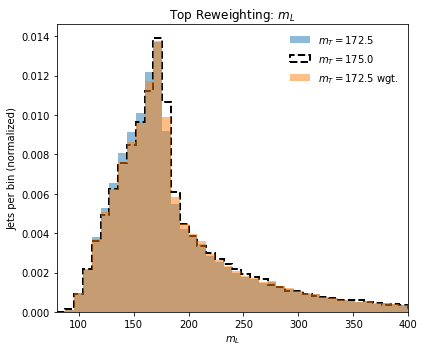

[0.9991482335768842, 0.998759583841506]
Iteration:  92


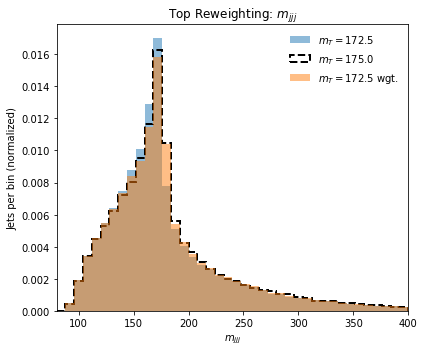

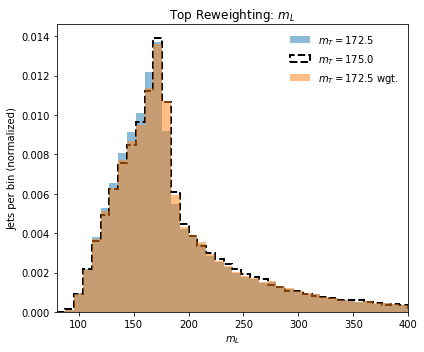

[0.9994504968891837, 0.9994308193111747]
Iteration:  93


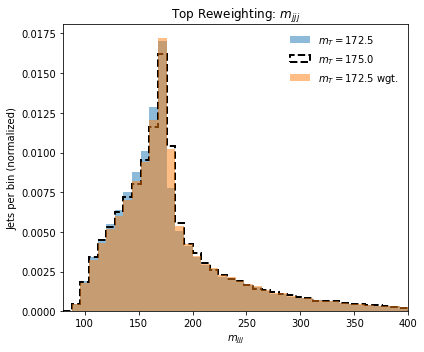

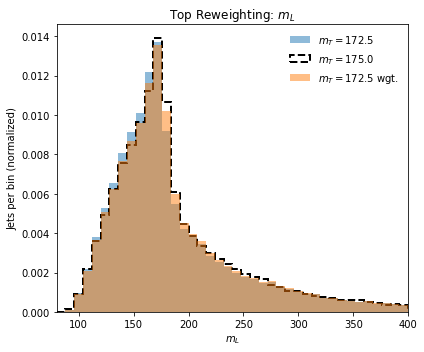

[0.998752850193257, 0.9991643609581112]
Iteration:  94


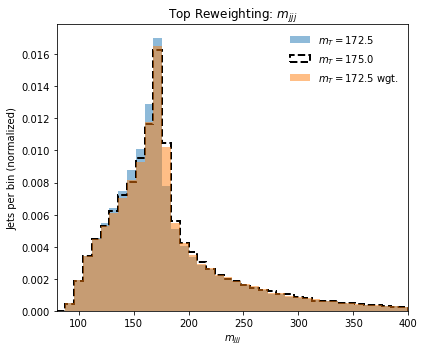

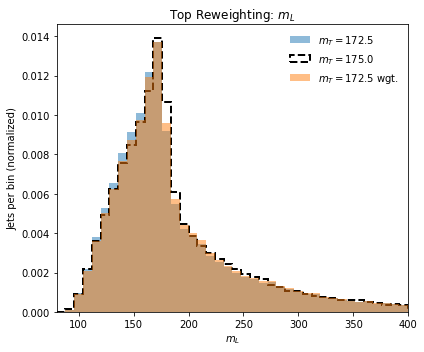

[0.9996039807278905, 0.9978442190550999]
Iteration:  95


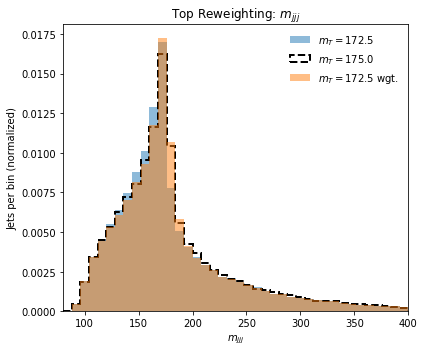

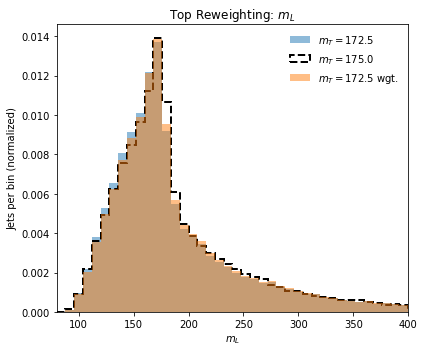

[0.9990030414087153, 0.9973195762551974]
Iteration:  96


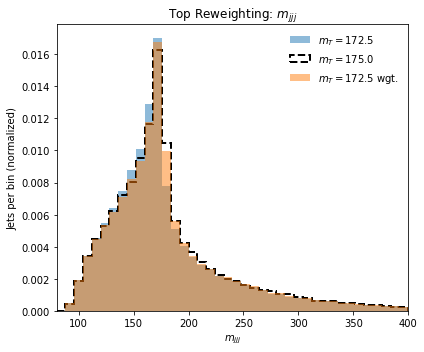

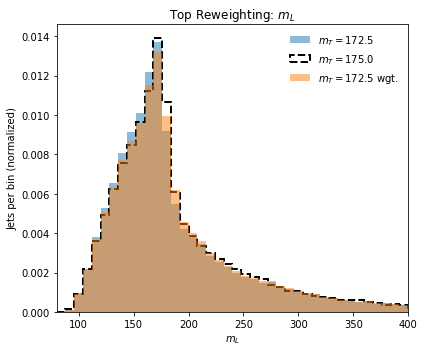

[0.9992822177747932, 0.9986005857649164]
Iteration:  97


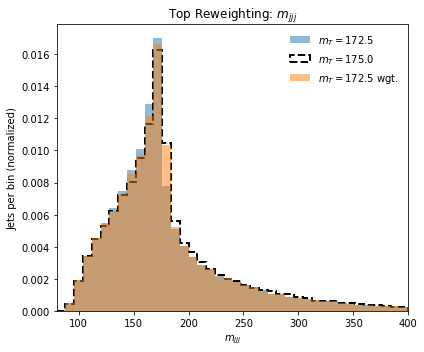

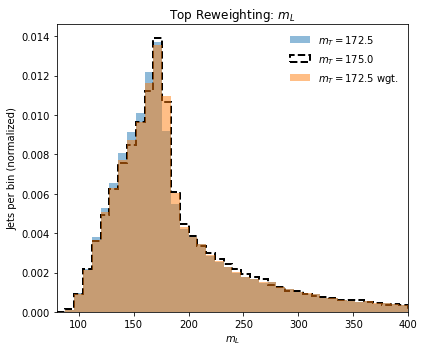

[0.9993076250576896, 0.9992453002737665]
Iteration:  98


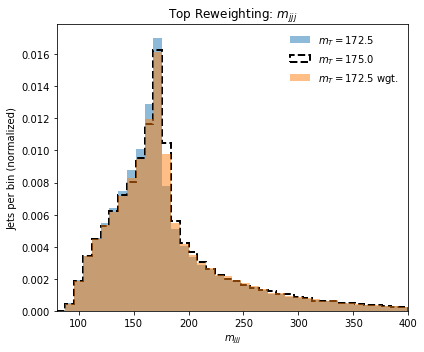

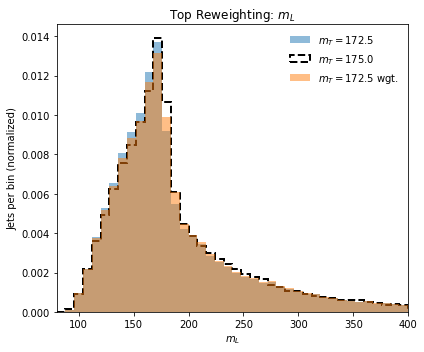

[0.999296306515805, 0.9980927823972686]
Iteration:  99


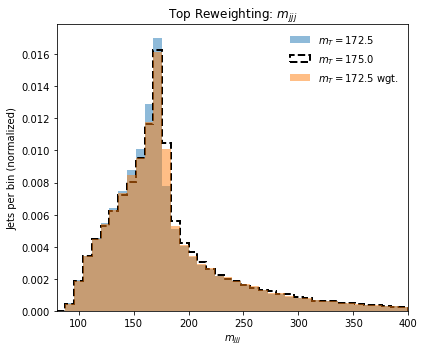

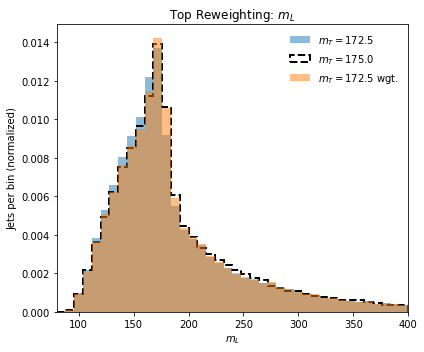

[0.9994408285455937, 0.9995551076818231]
Iteration:  100


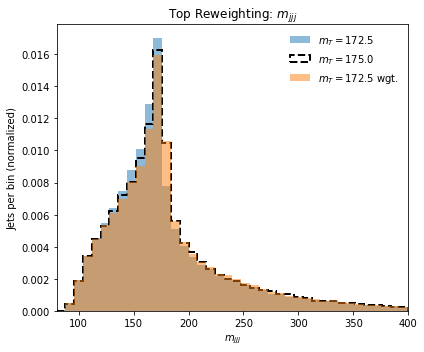

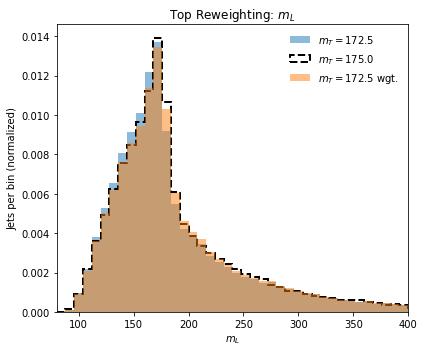

[0.9995446656222582, 0.9993068350349751]
Restoring best weights


In [16]:
iterations = 100

dctr_weights = 0
best_cor = [0, 0]
for iteration in range(iterations):
    print("Iteration: ", iteration + 1)

    X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

    K.clear_session()
    inputs = Input((3, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

    outputs = Dense(2, activation='softmax')(hidden_layer_3)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])

    history = dctr.fit(X_train,
                       Y_train,
                       epochs=1000,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=0,
                       callbacks=[earlystopping])

    weights_1 = reweight(default_dataset=tf.convert_to_tensor((test_dataset_0_obs/1000.),dtype=tf.float32), mT=((175.0/1000)))
    weights_1 = K.eval(weights_1)

    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting: $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj = plt.hist(test_dataset_1_obs[:, 0],
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights_1,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting: $m_L$")
    hist0_mL = plt.hist(test_dataset_0_obs[:, 1],
                        bins=bins,
                        label=label_0,
                        **plot_style_1)
    hist1_mL = plt.hist(test_dataset_1_obs[:, 1],
                        bins=bins,
                        label=label_1,
                        **plot_style_0)
    hist2_mL = plt.hist(test_dataset_0_obs[:, 1],
                        bins=bins,
                        label=label_0 + ' wgt.',
                        weights=weights_1,
                        **plot_style_1)

    plt.xlabel('$m_L$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()

    correlation = [
        cv2.compareHist(plt_hist_to_cv(hist1_mjjj),
                        plt_hist_to_cv(hist2_mjjj),
                        method=0),
        cv2.compareHist(plt_hist_to_cv(hist1_mL),
                        plt_hist_to_cv(hist2_mL),
                        method=0)
    ]
    print(correlation)
    if np.mean(correlation) > np.mean(best_cor):
        
        best_cor = correlation
        dctr_weights = dctr.get_weights()
        
    if all(val > 0.9999 for val in correlation):
        print("Success")
        break
    if iteration == 99:
        print("Restoring best weights")
        dctr.set_weights(dctr_weights)

In [17]:
# print("Number of initializations failed: ", n_fail, "/", iterations)
# print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

# print("Number of initializations succeeded: ", n_succ, "/", iterations)
# print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

# Plot History

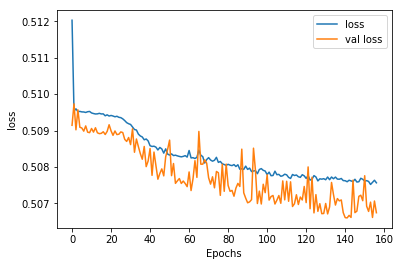

In [18]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Validation

### Load Datasets

### Get weights

In [19]:
weights_0 = reweight(default_dataset=tf.convert_to_tensor((test_dataset_0_obs/1000.),dtype=tf.float32), mT=(172.5/1000.))
weights_0 = K.eval(weights_0)
weights_1 = reweight(default_dataset=tf.convert_to_tensor((test_dataset_0_obs/1000),dtype=tf.float32), mT=(175.0/1000.))
weights_1 = K.eval(weights_1)

### Analyze weights

In [20]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

6.6351085
0.3068184
8.06196
0.30780688


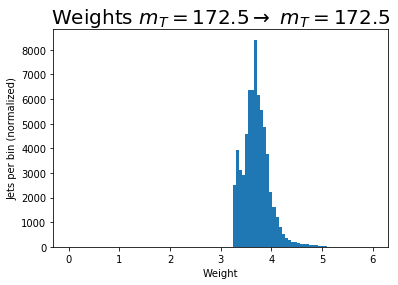

In [21]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

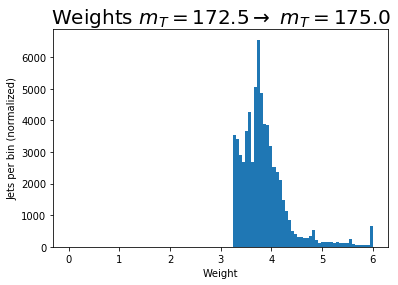

In [22]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()

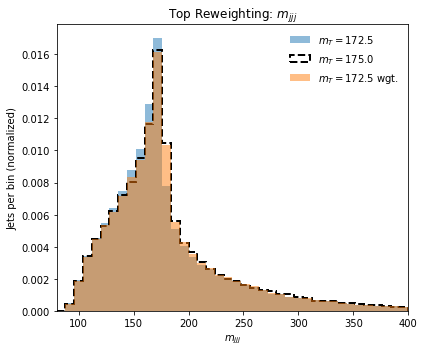

In [23]:
plt.figure(figsize=(6, 5))
plt.title("Top Reweighting: $m_{jjj}$")
bins = np.linspace(80, 400, 41)
hist0_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                      bins=bins,
                      label=label_0,
                      **plot_style_1)
hist1_mjjj = plt.hist(test_dataset_1_obs[:, 0],
                      bins=bins,
                      label=label_1,
                      **plot_style_0)
hist2_mjjj = plt.hist(test_dataset_0_obs[:, 0],
                      bins=bins,
                      label=label_0 + ' wgt.',
                      weights=weights_1,
                      **plot_style_1)
plt.xlabel('$m_{jjj}$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80, 400])
make_legend()
plt.show()

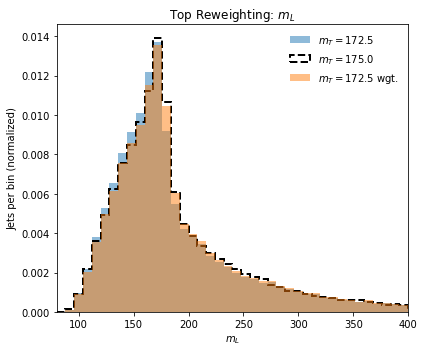

In [24]:
plt.figure(figsize=(6, 5))
plt.title("Top Reweighting: $m_L$")
hist0_mL = plt.hist(test_dataset_0_obs[:, 1],
                    bins=bins,
                    label=label_0,
                    **plot_style_1)
hist1_mL = plt.hist(test_dataset_1_obs[:, 1],
                    bins=bins,
                    label=label_1,
                    **plot_style_0)
hist2_mL = plt.hist(test_dataset_0_obs[:, 1],
                    bins=bins,
                    label=label_0 + ' wgt.',
                    weights=weights_1,
                    **plot_style_1)

plt.xlabel('$m_L$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80, 400])
make_legend()
plt.show()

In [25]:
correlation = [
    cv2.compareHist(plt_hist_to_cv(hist1_mjjj),
                    plt_hist_to_cv(hist2_mjjj),
                    method=0),
    cv2.compareHist(plt_hist_to_cv(hist1_mL),
                    plt_hist_to_cv(hist2_mL),
                    method=0)
]
print(correlation)

[0.9997465932315737, 0.9994683670353522]


In [27]:
X_default = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,:2]
X_unknown = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,:2]

Y_default = np.zeros_like(X_default[:,0])
Y_unknown = np.ones_like(X_unknown[:,0])

In [28]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)
X_fit = X_fit/1000.
Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)

In [29]:
X_train, X_test, Y_train, Y_test = data_split(X_fit, Y_fit, test=0.5, shuffle=True)

X_train = X_train[:67500]
X_test = X_test[:67500]
Y_train = Y_train[:67500]
Y_test = Y_test[:67500]

In [30]:
myinputs = Input(shape=(2,), dtype = tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)
          
model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 500

earlystopping = EarlyStopping(patience = 10, 
                              restore_best_weights=True)

def my_loss_wrapper(inputs,val=0):
    x  = inputs
    x = K.gather(x, np.arange(batch_size))
    w = reweight(x, val)
    
    def my_loss(y_true,y_pred):
        # Mean Squared Loss
        t_loss = (y_true)*(y_true - y_pred)**2+(w)*(1.-y_true)*(y_true - y_pred)**2
        # Categorical Cross-Entropy Loss
        
        #Clip the prediction value to prevent NaN's and Inf's
        """        
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        t_loss = -((y_true)*K.log(y_pred) +w*(1-y_true)*K.log(1-y_pred))
        """
        return K.mean(t_loss)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


testing theta = : 0.17
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 40us/step - loss: 0.3937 - acc: 0.4940 - val_loss: 0.3931 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3935 - acc: 0.4940 - val_loss: 0.3933 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3935 - acc: 0.4940 - val_loss: 0.3931 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3935 - acc: 0.4940 - val_loss: 0.3932 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3935 - acc: 0.4940 - val_loss: 0.3932 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3935 - acc: 0.4940 - val_loss: 0.3930 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3935 - acc: 0.494

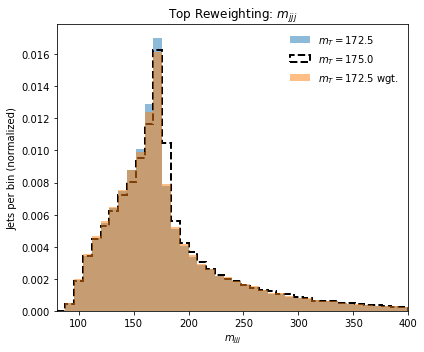

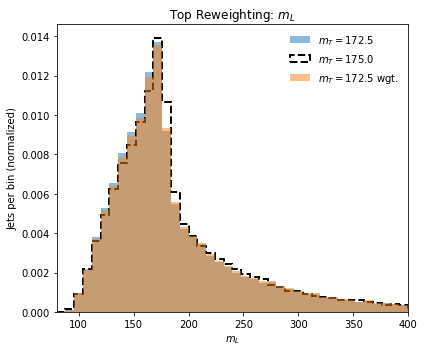

testing theta = : 0.1705
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 41us/step - loss: 0.3939 - acc: 0.4940 - val_loss: 0.3936 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3939 - acc: 0.4941 - val_loss: 0.3937 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3938 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3939 - acc: 0.4940 - val_loss: 0.3936 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3939 - acc: 0.4940 - val_loss: 0.3940 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3940 - acc: 0.4940 - val_loss: 0.3935 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3939 - acc: 0.4

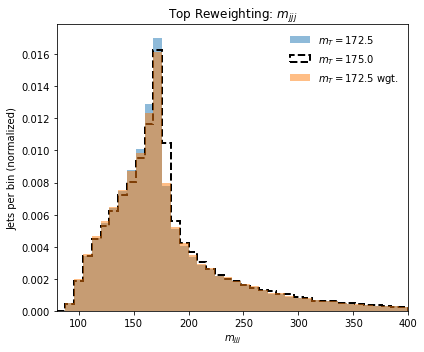

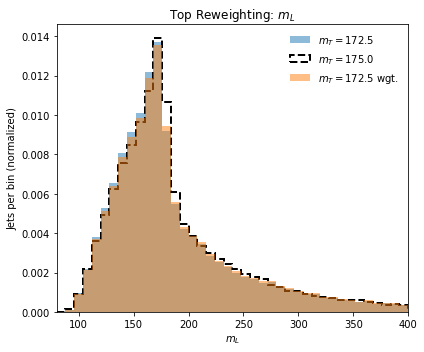

testing theta = : 0.171
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 40us/step - loss: 0.3943 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3943 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3943 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3943 - acc: 0.4939 - val_loss: 0.3941 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3944 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3943 - acc: 0.4940 - val_loss: 0.3939 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3943 - acc: 0.49

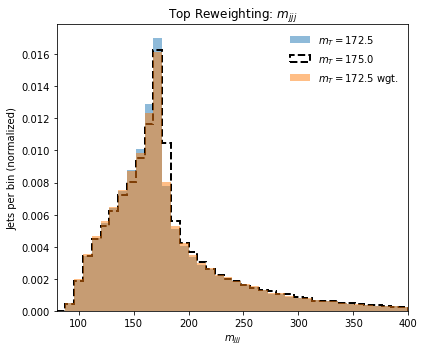

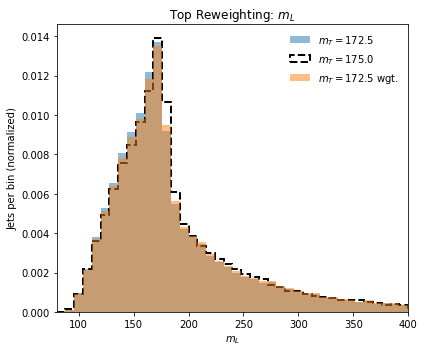

testing theta = : 0.1715
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 42us/step - loss: 0.3948 - acc: 0.4940 - val_loss: 0.3943 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3948 - acc: 0.4940 - val_loss: 0.3945 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3947 - acc: 0.4940 - val_loss: 0.3945 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3947 - acc: 0.4940 - val_loss: 0.3947 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3947 - acc: 0.4940 - val_loss: 0.3946 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3948 - acc: 0.4940 - val_loss: 0.3944 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3948 - acc: 0.4

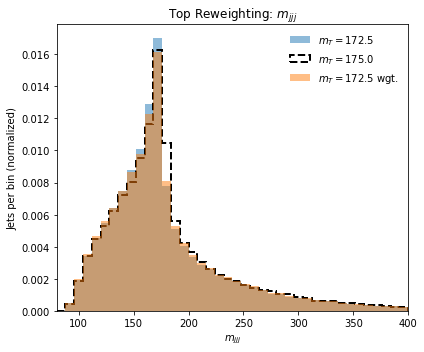

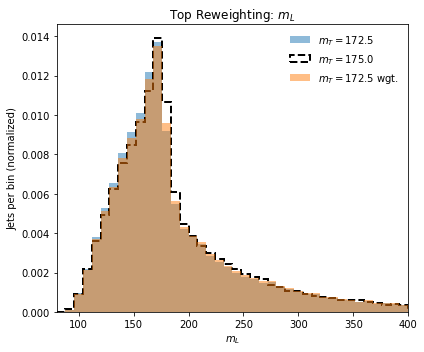

testing theta = : 0.172
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 43us/step - loss: 0.3953 - acc: 0.4940 - val_loss: 0.3949 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3953 - acc: 0.4940 - val_loss: 0.3952 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3953 - acc: 0.4940 - val_loss: 0.3951 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3953 - acc: 0.4940 - val_loss: 0.3950 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3954 - acc: 0.4940 - val_loss: 0.3951 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3954 - acc: 0.4940 - val_loss: 0.3951 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.3954 - acc: 0.49

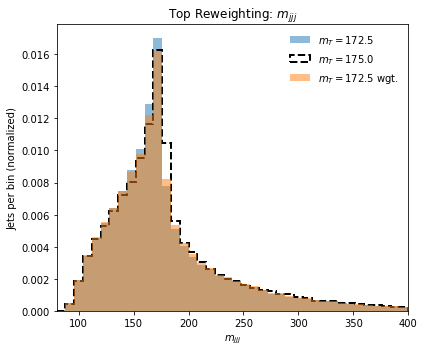

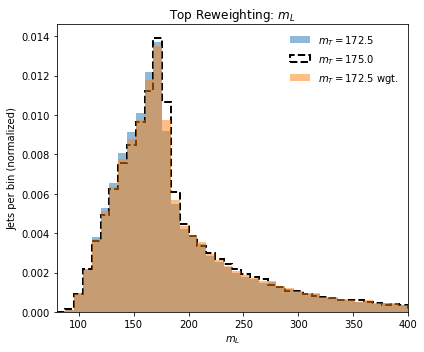

testing theta = : 0.1725
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 46us/step - loss: 0.3960 - acc: 0.4940 - val_loss: 0.3955 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3960 - acc: 0.4940 - val_loss: 0.3956 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3959 - acc: 0.4941 - val_loss: 0.3956 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3960 - acc: 0.4940 - val_loss: 0.3956 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3959 - acc: 0.4940 - val_loss: 0.3958 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3960 - acc: 0.4940 - val_loss: 0.3955 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3959 - acc: 0.4

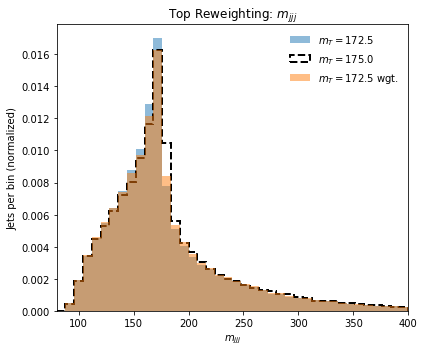

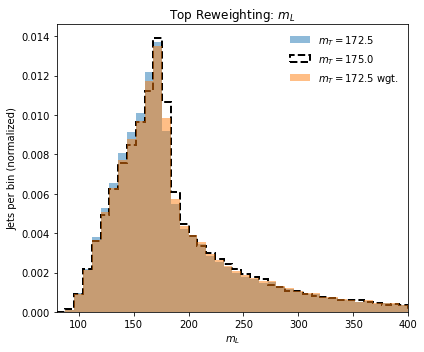

testing theta = : 0.173
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 45us/step - loss: 0.3968 - acc: 0.4940 - val_loss: 0.3964 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3967 - acc: 0.4940 - val_loss: 0.3964 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3966 - acc: 0.4940 - val_loss: 0.3963 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3967 - acc: 0.4940 - val_loss: 0.3964 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3967 - acc: 0.4940 - val_loss: 0.3963 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3967 - acc: 0.4941 - val_loss: 0.3963 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3967 - acc: 0.49

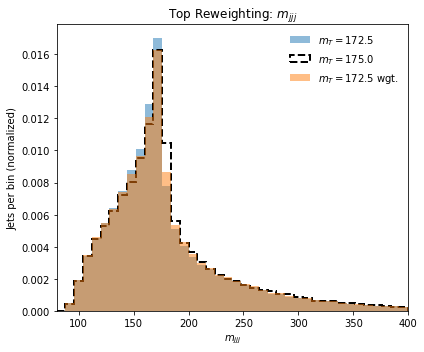

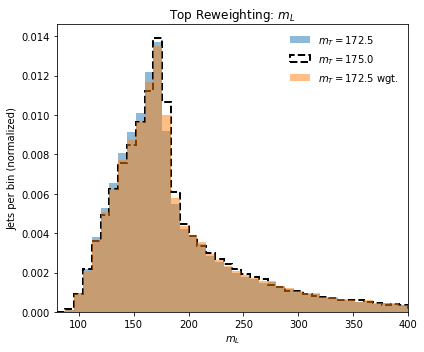

testing theta = : 0.1735
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 46us/step - loss: 0.3974 - acc: 0.4940 - val_loss: 0.3970 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3974 - acc: 0.4940 - val_loss: 0.3970 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3974 - acc: 0.4940 - val_loss: 0.3970 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3975 - acc: 0.4940 - val_loss: 0.3971 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3974 - acc: 0.4940 - val_loss: 0.3970 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3974 - acc: 0.4940 - val_loss: 0.3973 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3974 - acc: 0.4

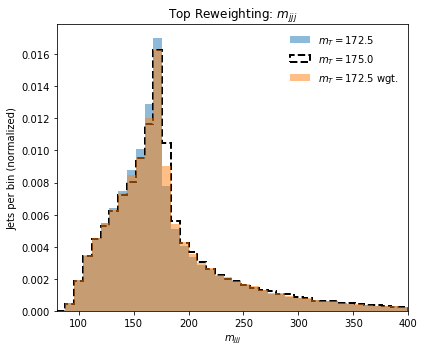

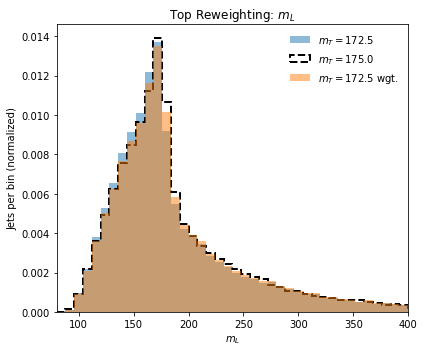

testing theta = : 0.174
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 50us/step - loss: 0.3982 - acc: 0.4940 - val_loss: 0.3977 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3982 - acc: 0.4940 - val_loss: 0.3978 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3983 - acc: 0.4940 - val_loss: 0.3980 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3983 - acc: 0.4940 - val_loss: 0.3980 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3982 - acc: 0.4940 - val_loss: 0.3978 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3982 - acc: 0.4940 - val_loss: 0.3980 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3983 - acc: 0.49

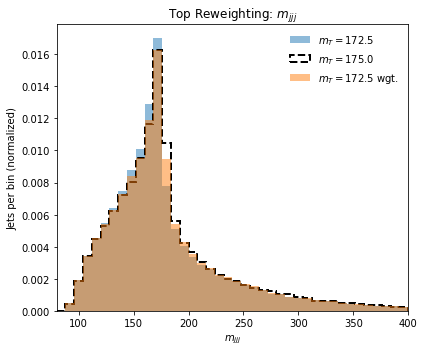

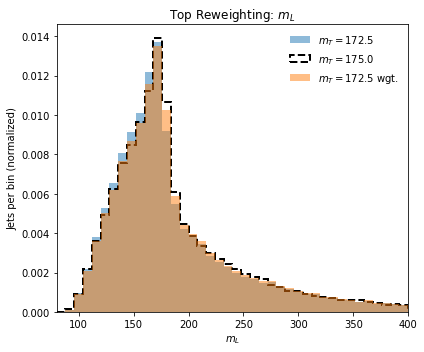

testing theta = : 0.1745
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 49us/step - loss: 0.3990 - acc: 0.4940 - val_loss: 0.3985 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3990 - acc: 0.4941 - val_loss: 0.3986 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3991 - acc: 0.4940 - val_loss: 0.3986 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3990 - acc: 0.4940 - val_loss: 0.3987 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3991 - acc: 0.4940 - val_loss: 0.3986 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3990 - acc: 0.4940 - val_loss: 0.3986 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3990 - acc: 0.4

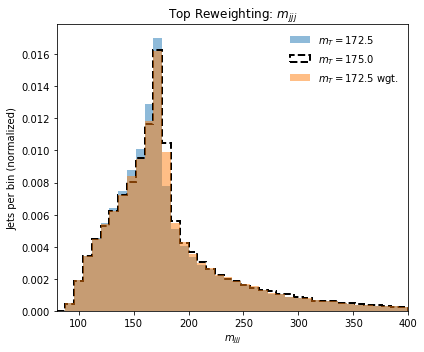

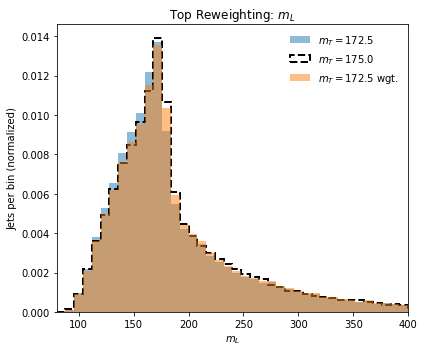

testing theta = : 0.175
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 3s 50us/step - loss: 0.3999 - acc: 0.4940 - val_loss: 0.3993 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.4940 - val_loss: 0.3995 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.4940 - val_loss: 0.3994 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.4940 - val_loss: 0.3995 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.4940 - val_loss: 0.3996 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.4940 - val_loss: 0.3993 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.3998 - acc: 0.49

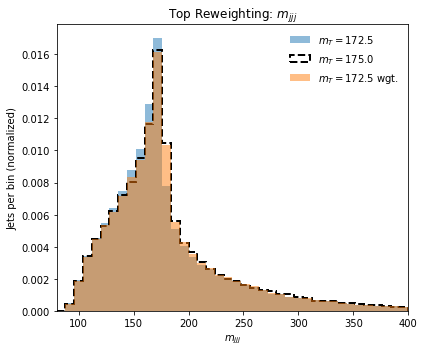

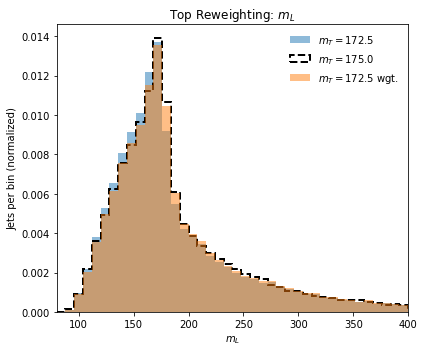

testing theta = : 0.1755
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 59us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4002 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 10us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4001 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4001 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4001 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4002 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4006 - acc: 0.4940 - val_loss: 0.4005 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4006 - acc: 0.4

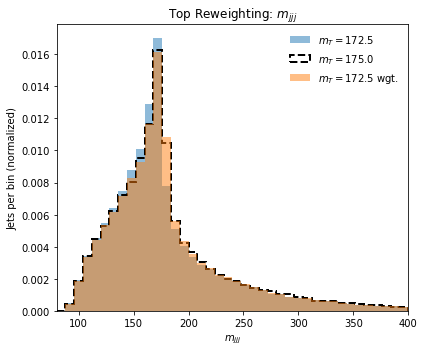

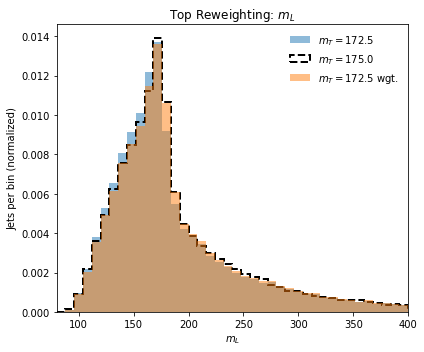

testing theta = : 0.176
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 59us/step - loss: 0.4014 - acc: 0.4940 - val_loss: 0.4008 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4014 - acc: 0.4940 - val_loss: 0.4008 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4014 - acc: 0.4940 - val_loss: 0.4009 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4013 - acc: 0.4940 - val_loss: 0.4009 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4014 - acc: 0.4940 - val_loss: 0.4009 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4014 - acc: 0.4940 - val_loss: 0.4009 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4013 - acc: 0.49

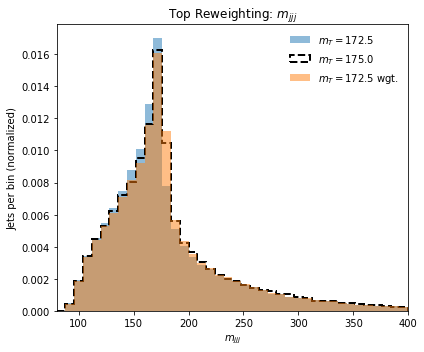

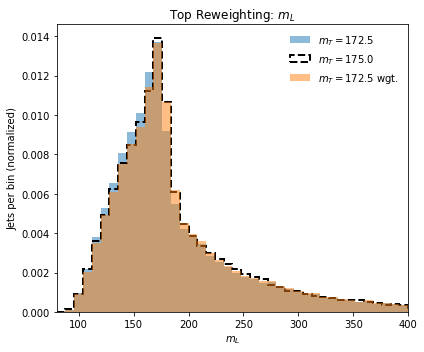

testing theta = : 0.1765
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 61us/step - loss: 0.4021 - acc: 0.4940 - val_loss: 0.4016 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4022 - acc: 0.4940 - val_loss: 0.4016 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4021 - acc: 0.4940 - val_loss: 0.4016 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4021 - acc: 0.4940 - val_loss: 0.4018 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4022 - acc: 0.4940 - val_loss: 0.4016 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4021 - acc: 0.4940 - val_loss: 0.4016 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4021 - acc: 0.4

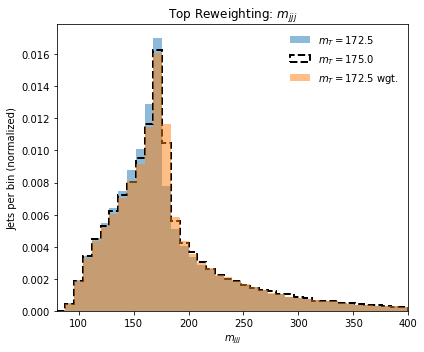

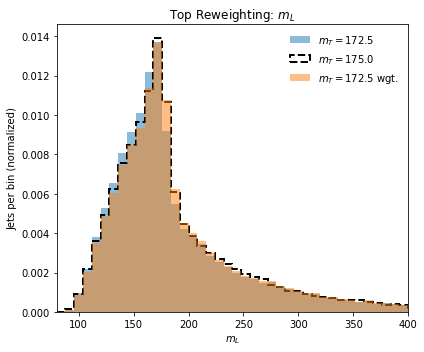

testing theta = : 0.177
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 64us/step - loss: 0.4029 - acc: 0.4940 - val_loss: 0.4023 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4029 - acc: 0.4941 - val_loss: 0.4023 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4029 - acc: 0.4940 - val_loss: 0.4023 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4029 - acc: 0.4940 - val_loss: 0.4023 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4029 - acc: 0.4940 - val_loss: 0.4024 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4029 - acc: 0.4940 - val_loss: 0.4023 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4029 - acc: 0.49

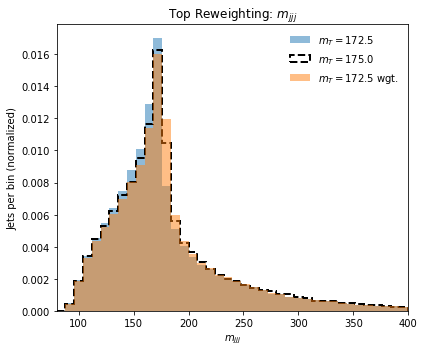

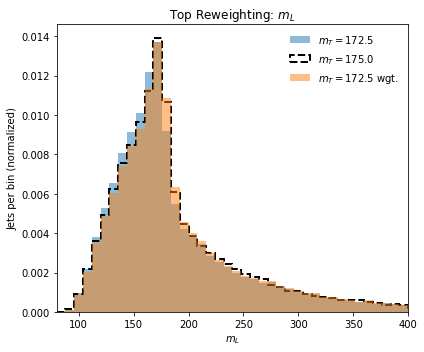

testing theta = : 0.1775
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 65us/step - loss: 0.4037 - acc: 0.4940 - val_loss: 0.4031 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4037 - acc: 0.4940 - val_loss: 0.4031 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4036 - acc: 0.4940 - val_loss: 0.4033 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4037 - acc: 0.4940 - val_loss: 0.4031 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4036 - acc: 0.4940 - val_loss: 0.4032 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4037 - acc: 0.4941 - val_loss: 0.4032 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4037 - acc: 0.4

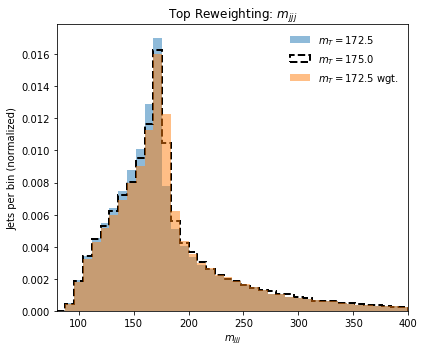

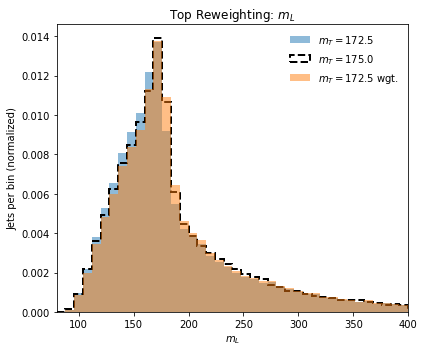

testing theta = : 0.178
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 4s 64us/step - loss: 0.4045 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4044 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4044 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4952
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4045 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4044 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4044 - acc: 0.4940 - val_loss: 0.4039 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4044 - acc: 0.49

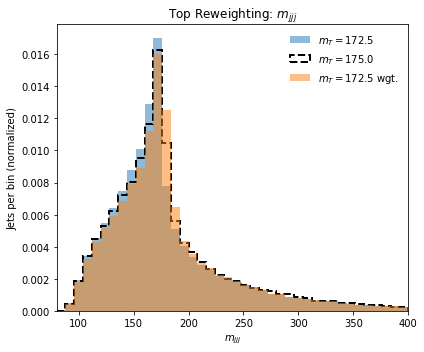

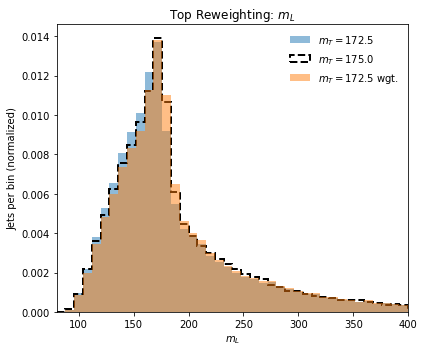

testing theta = : 0.1785
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 5s 69us/step - loss: 0.4052 - acc: 0.4941 - val_loss: 0.4047 - val_acc: 0.4952
Epoch 2/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4052 - acc: 0.4940 - val_loss: 0.4046 - val_acc: 0.4952
Epoch 3/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4051 - acc: 0.4940 - val_loss: 0.4047 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4052 - acc: 0.4940 - val_loss: 0.4046 - val_acc: 0.4952
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4052 - acc: 0.4940 - val_loss: 0.4046 - val_acc: 0.4952
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4052 - acc: 0.4940 - val_loss: 0.4047 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4051 - acc: 0.4

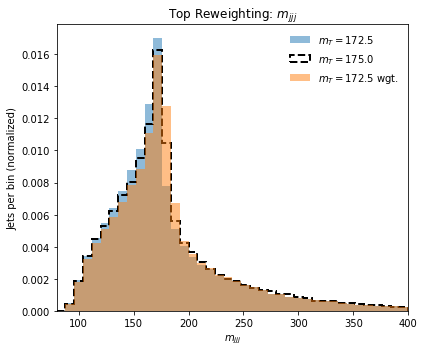

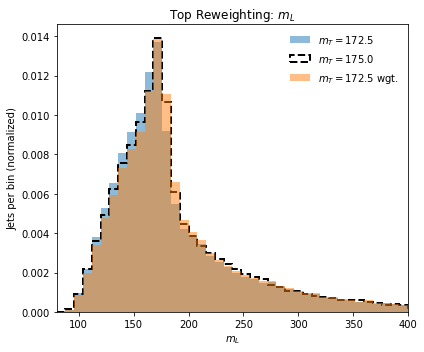

testing theta = : 0.179
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 5s 70us/step - loss: 0.4058 - acc: 0.4940 - val_loss: 0.4054 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.4941 - val_loss: 0.4053 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.4940 - val_loss: 0.4053 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.4940 - val_loss: 0.4055 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.4940 - val_loss: 0.4055 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.4940 - val_loss: 0.4053 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4058 - acc: 0.49

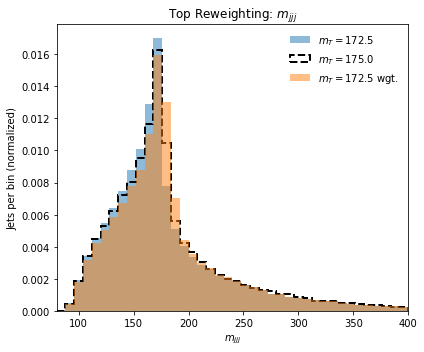

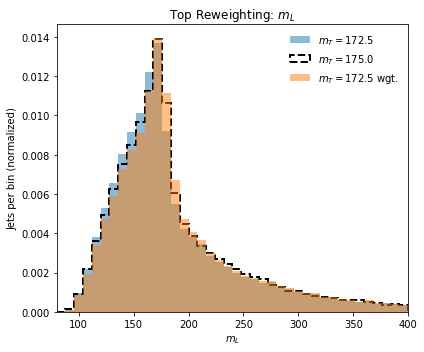

testing theta = : 0.1795
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 5s 72us/step - loss: 0.4065 - acc: 0.4940 - val_loss: 0.4061 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4066 - acc: 0.4941 - val_loss: 0.4061 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4066 - acc: 0.4940 - val_loss: 0.4063 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4065 - acc: 0.4941 - val_loss: 0.4060 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4065 - acc: 0.4940 - val_loss: 0.4061 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4065 - acc: 0.4940 - val_loss: 0.4061 - val_acc: 0.4953
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4065 - acc: 0.4

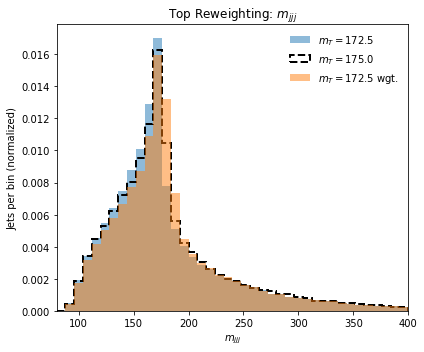

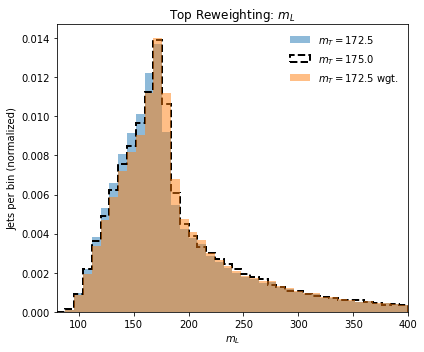

testing theta = : 0.18
Train on 67500 samples, validate on 67500 samples
Epoch 1/100
67500/67500 [==============================] - 5s 72us/step - loss: 0.4072 - acc: 0.4940 - val_loss: 0.4068 - val_acc: 0.4953
Epoch 2/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4072 - acc: 0.4940 - val_loss: 0.4068 - val_acc: 0.4953
Epoch 3/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4071 - acc: 0.4941 - val_loss: 0.4068 - val_acc: 0.4953
Epoch 4/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4071 - acc: 0.4941 - val_loss: 0.4069 - val_acc: 0.4953
Epoch 5/100
67500/67500 [==============================] - 1s 12us/step - loss: 0.4070 - acc: 0.4941 - val_loss: 0.4068 - val_acc: 0.4953
Epoch 6/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4071 - acc: 0.4941 - val_loss: 0.4067 - val_acc: 0.4952
Epoch 7/100
67500/67500 [==============================] - 1s 11us/step - loss: 0.4070 - acc: 0.494

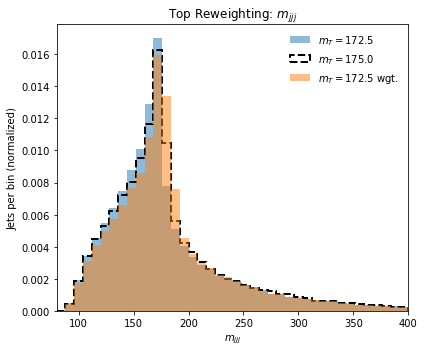

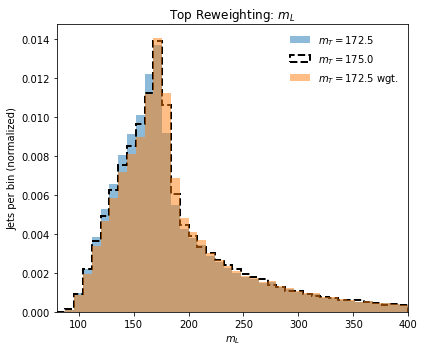

[0.3934898716432077, 0.3937946054670546, 0.39421282763834353, 0.39469633963372974, 0.39528196233290214, 0.39586191994172554, 0.39661291705237495, 0.3974055669925831, 0.3981558960896951, 0.3989913337760501, 0.3997339478245488, 0.4005235325407099, 0.4013320995701684, 0.40209197644834166, 0.40284530939879243, 0.4036164899667104, 0.40436627599928116, 0.4050275358888838, 0.40572760259663615, 0.4063008334901598, 0.4069101945117668]


In [39]:
thetas = np.linspace(170, 180, 21)
lvals = []
vlvals = []
cor = []

for theta in thetas:
    theta /= 1000.
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(myinputs, theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              Y_train,
              epochs=100,
              batch_size=batch_size,
              validation_data=(np.array(X_test), Y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print(lvals)

    weights_1 = reweight(default_dataset=tf.convert_to_tensor(
        X_fit[Y_fit == 0], dtype=tf.float32),
                         mT=(theta))
    weights_1 = K.eval(weights_1)
    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting: $m_{jjj}$")
    bins = np.linspace(80, 400, 41)
    hist0_mjjj = plt.hist(X_fit[:, 0][Y_fit == 0]*1000,
                          bins=bins,
                          label=label_0,
                          **plot_style_1)
    hist1_mjjj = plt.hist(X_fit[:, 0][Y_fit == 1]*1000,
                          bins=bins,
                          label=label_1,
                          **plot_style_0)
    hist2_mjjj = plt.hist(X_fit[:, 0][Y_fit == 0]*1000,
                          bins=bins,
                          label=label_0 + ' wgt.',
                          weights=weights_1,
                          **plot_style_1)
    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.title("Top Reweighting: $m_L$")
    hist0_mL = plt.hist(X_fit[:, 1][Y_fit == 0]*1000,
                        bins=bins,
                        label=label_0,
                        **plot_style_1)
    hist1_mL = plt.hist(X_fit[:, 1][Y_fit == 1]*1000,
                        bins=bins,
                        label=label_1,
                        **plot_style_0)
    hist2_mL = plt.hist(X_fit[:, 1][Y_fit == 0]*1000,
                        bins=bins,
                        label=label_0 + ' wgt.',
                        weights=weights_1,
                        **plot_style_1)

    plt.xlabel('$m_L$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80, 400])
    make_legend()
    plt.show()

    correlation = [
        cv2.compareHist(plt_hist_to_cv(hist1_mjjj),
                        plt_hist_to_cv(hist2_mjjj),
                        method=0),
        cv2.compareHist(plt_hist_to_cv(hist1_mL),
                        plt_hist_to_cv(hist2_mL),
                        method=0)
    ]
    
    cor += [np.mean(correlation)]
    print
    pass
print(lvals)

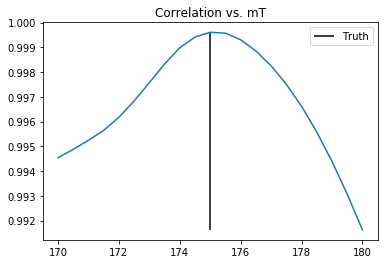

In [40]:
plt.title("Correlation vs. mT")
plt.plot(thetas, cor)
plt.vlines(175, min(cor), max(cor), label = 'Truth')
plt.legend()
plt.show()

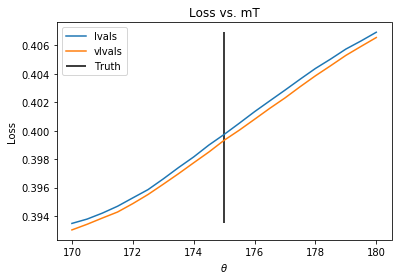

In [41]:
plt.title("Loss vs. mT")
plt.plot(thetas,lvals, label = 'lvals')
plt.plot(thetas,vlvals, label = 'vlvals')
plt.vlines(175, min(lvals), max(lvals), label = 'Truth')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# iterations = 5
# for i in range(iterations):
#     print("Iteration: ", i)
    
#     K.clear_session()
    
#     inputs = Input((2,))
#     hidden_layer_1 = Dense(50, activation='relu')(inputs)
#     hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#     hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

#     outputs = Dense(2, activation='softmax')(hidden_layer_3)

#     dctr = Model(inputs = inputs, outputs = outputs)
#     dctr.compile(loss='categorical_crossentropy', optimizer='Adam')
    
#     history = dctr.fit(X_train,
#                Y_train,
#                epochs=200,
#                batch_size=1000,
#                validation_data=(X_val, Y_val),
#                callbacks=[earlystopping],
#                verbose=0)
    
#     weights_0 = reweight(default_dataset=test_dataset_0_mjjj,
#                      mT=172.5)

#     weights_1 = reweight(default_dataset=test_dataset_0_mjjj,
#                          mT=175.0)
    
#     clip_val = 6
#     bins = np.linspace(0, clip_val, 101)
#     plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
#     plt.xlabel("Weight")
#     plt.ylabel('Jets per bin (normalized)')
#     plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
#     plt.show()
    
#     clip_val = 6
#     bins = np.linspace(0, clip_val, 101)
#     plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
#     plt.xlabel("Weight")
#     plt.ylabel('Jets per bin (normalized)')
#     plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
#     plt.show()
    
#     plt.figure(figsize=(6,5))
#     plt.title("Top Reweighting: $m_{jjj}$ only")
#     bins = np.linspace(80,400,41)
#     hist0 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0, **plot_style_1)
#     hist1 = plt.hist(test_dataset_1_mjjj, bins = bins, label = label_1, **plot_style_0)
#     hist2 = plt.hist(test_dataset_0_mjjj, bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

#     plt.xlabel('$m_{jjj}$')
#     plt.ylabel('Jets per bin (normalized)')
#     plt.xlim([80,400])
#     make_legend()
#     plt.savefig("Top Reweighting: m_{jjj} only.png")
#     plt.show()